# Creative Extension Analysis 

## Analysing plane travels and predicting people's home area based on their flight patterns

In this notebook, we propose a creative extension analysis of the paper _Friendship and Mobility: User Movement in Location-Based Social Networks_. We chose to answer multiple research questions by using the same datasets (check-ins) and an additional one (airports). 

In particular, we aim to:
- Find which countries travel the most.
- Detect patterns in global air traffic.
- Describe the network of airports.
- Find the most visited destinations by country.
- See if there is a conection between friends and visited countries.
- Check if it is possible to predict home areas based on travel patterns.

All plots in this Notebook are present in the datastory, so if you don't directly see them here you can eaither look at the [datastory](https://valentingarnier.github.io/) or open this notebook in Jupyter Lab.

## Tools

In [1]:
#General imports
import networkx as nx
import pandas as pd
import numpy as np
import math
from numba import njit
import itertools
import reverse_geocoder
import pickle
import os
import pycountry_convert as pc
from operator import itemgetter
import pycountry

#Plots
import folium
import pylab as pl
import matplotlib.pyplot as plt
from folium import plugins
import plotly.graph_objs as go
import plotly.express as px

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline        import Pipeline


In [2]:
%load_ext blackcellmagic

## Load the Data

We load the check-ins datasets, the new airport dataset and the friendship graphs.

In [3]:
data_folder = "data"

In [4]:
checkins_b = pd.read_csv(
    os.path.join(data_folder, "loc-brightkite_totalCheckins.txt.gz"),
    compression="gzip",
    delimiter="\t",
    usecols=[0, 1, 2, 3],
    names=["user", "checkin_time", "latitude", "longitude"],
    parse_dates=["checkin_time"],
)

checkins_g = pd.read_csv(
    os.path.join(data_folder, "loc-gowalla_totalCheckins.txt.gz"),
    compression="gzip",
    delimiter="\t",
    usecols=[0, 1, 2, 3],
    names=["user", "checkin_time", "latitude", "longitude"],
    parse_dates=["checkin_time"],
)

airports = pd.read_csv(
    os.path.join(data_folder, "airports.csv"),
    usecols=[2, 3, 4, 5, 8],
)

countries = pd.read_csv(
    os.path.join(data_folder, "countries.csv"),
    usecols=[1, 2],
    header=0,
    names=["iso_country", "country"],
)

#Friendship edges
friendships_b = pd.read_csv(
    os.path.join(data_folder, "loc-gowalla_edges.txt.gz"),
    compression="gzip",
    delimiter="\t",
    names=["user1", "user2"]
)

friendships_g = pd.read_csv(
    os.path.join(data_folder, "loc-brightkite_edges.txt.gz"),
    compression="gzip",
    delimiter="\t",
    names=["user1", "user2"]
)

In the following cells, we will only display dataframes for Brightkite, they are similar for Gowalla.

In [5]:
checkins_b.head()

user              checkin_time   latitude   longitude
0     0 2010-10-17 01:48:53+00:00  39.747652 -104.992510
1     0 2010-10-16 06:02:04+00:00  39.891383 -105.070814
2     0 2010-10-16 03:48:54+00:00  39.891077 -105.068532
3     0 2010-10-14 18:25:51+00:00  39.750469 -104.999073
4     0 2010-10-14 00:21:47+00:00  39.752713 -104.996337

In [6]:
friendships_b.head()

user1  user2
0      0      1
1      0      2
2      0      3
3      0      4
4      0      5

## Preprocessing Check-ins Datasets



In [7]:
print(f"Brightkite checkins dataset has {len(checkins_b)} rows.")
print(f"Gowalla checkins dataset has {len(checkins_g)} rows.")

Brightkite checkins dataset has 4747287 rows.
Gowalla checkins dataset has 6442892 rows.


We check for missing values in both datasets

In [8]:
NaN_rows_b = np.count_nonzero(np.count_nonzero(checkins_b.isnull(), axis=1))
NaN_rows_g = np.count_nonzero(np.count_nonzero(checkins_g.isnull(), axis=1))
print(f"There are {NaN_rows_b} rows in Brightkite with at least a NaN value.")
print(f"There are {NaN_rows_g} rows in Gowalla with at least a NaN value.")
print("\nWhere the NaN values are in Brightkite:")
checkins_b.isnull().any()

There are 6 rows in Brightkite with at least a NaN value.
There are 0 rows in Gowalla with at least a NaN value.

Where the NaN values are in Brightkite:


user            False
checkin_time     True
latitude         True
longitude        True
dtype: bool

We see that Brightkite has just 6 rows with a NaN value. As we can see above thes NaN values are in the latitude and longitude column. We will remove the rows containg NaNs since these are probably some measuring mistakes.

In [9]:
checkins_b = checkins_b.dropna()

We notice that some values are incorrect in the datasets.  
Latitude should be bounded: $$ latitude \in [-90, 90]$$
Longitude should also be bounded: $$longitude \in [-180, 180]$$
We notice that both datasets have incorrect values only for their latitude:

In [10]:
wrong_lat_b = len(
    checkins_b[
        (checkins_b.latitude < -90)
        | (checkins_b.latitude > 90)
    ]
)
wrong_long_b = len(
    checkins_b[
        (checkins_b.longitude < -180)
        | (checkins_b.longitude > 180)
    ]
)
print(
    f"There are {wrong_lat_b} datapoints with an incorrect latitude\n and {wrong_long_b} with an incorrect longitude in the brightkite dataset."
)

wrong_lat_g = len(
    checkins_g[
        (checkins_g.latitude < -90)
        | (checkins_g.latitude > 90)
    ]
)
wrong_long_g = len(
    checkins_g[
        (checkins_g.longitude < -180)
        | (checkins_g.longitude > 180)
    ]
)
print(
    f"There are {wrong_lat_g} datapoints with an incorrect latitude\n and {wrong_long_g} with an incorrect longitude in the gowalla dataset."
)

There are 109 datapoints with an incorrect latitude
 and 0 with an incorrect longitude in the brightkite dataset.
There are 29 datapoints with an incorrect latitude
 and 0 with an incorrect longitude in the gowalla dataset.


The incorrect latitudes are probably some type of errors that happen unfrequently. As we can see there are only 109 and 29 incorrect coordinates in the BrightKite and Gowalla dataframe respectively. These might be measuring errors from the user's device or some conversion error or error while saving the coordinates in the Dataframe.

We can also see that there are check-ins at coordinate (0,0). These are probably outliers since these coordinates are in the middle of the Atlantic Ocean. Even though Gowalla only has a few, we will remove these datapoints in both datasets. Even though some datapoints in the datasets might not be outliers but just tourists visiting the virtual [Null Island](https://fr.wikipedia.org/wiki/Null_Island), we can safely assume that noone's home can be located there and we thus will remove all check-ins at (0,0).

In [11]:
number_00_checkins_b = len(
    checkins_b[
        (checkins_b.latitude == 0)
        & (checkins_b.longitude == 0)
    ]
)

number_00_checkins_g = len(
    checkins_g[
        (checkins_g.latitude == 0)
        & (checkins_g.longitude == 0)
    ]
)

print(
    f"There are {number_00_checkins_b} datapoints at coordinates (0,0) in the Brightkite dataset."
)

print(
    f"There are {number_00_checkins_g} datapoints at coordinates (0,0) in the Gowalla dataset."
)

There are 256137 datapoints at coordinates (0,0) in the Brightkite dataset.
There are 135 datapoints at coordinates (0,0) in the Gowalla dataset.


There are far more errors in the Brightkite dataset suggesting that there is some difference in the way the two services handle coordinates. A reason might be that these errors are due to users' devices but in this case it would mean that almost all users with faulty devices are in Brightkite and none are in Gowalla. This might be explained by the fact that Gowalla might have more requirements for users' devices before they download their service (better OS version, better sensors....).  
Another reason might be that Gowalla has some mechanism to detect fault measurements and remove them.  
Another reason might be that Brightkite might allow users to have the app without using their GPS and saves all checkins with default coordinate (0,0). This might sound strange but maybe they still want to save users' checkins even though they don't have GPS coordinates. In this case it would have been more reasonable to put some other value to indicate a lack of GPS coordinates (ex. NaN). 

We can now just keep the coordinates with correct values and not at (0,0):

In [12]:
checkins_b = checkins_b[
    (checkins_b.latitude >= -90)
    & (checkins_b.latitude <= 90)
    & ~((checkins_b.latitude == 0) & (checkins_b.longitude == 0))
]

checkins_g = checkins_g[
    (checkins_g.latitude >= -90)
    & (checkins_g.latitude <= 90)
    & ~((checkins_g.latitude == 0) & (checkins_g.longitude == 0))
]

In [13]:
checkins_b.head()

user              checkin_time   latitude   longitude
0     0 2010-10-17 01:48:53+00:00  39.747652 -104.992510
1     0 2010-10-16 06:02:04+00:00  39.891383 -105.070814
2     0 2010-10-16 03:48:54+00:00  39.891077 -105.068532
3     0 2010-10-14 18:25:51+00:00  39.750469 -104.999073
4     0 2010-10-14 00:21:47+00:00  39.752713 -104.996337

## Work on Airport Dataset

In [14]:
airports.head()

type                                name  latitude_deg  \
0       heliport                   Total Rf Heliport     40.070801   
1  small_airport                Aero B Ranch Airport     38.704022   
2  small_airport                        Lowell Field     59.949200   
3  small_airport                        Epps Airpark     34.864799   
4         closed  Newport Hospital & Clinic Heliport     35.608700   

   longitude_deg iso_country  
0     -74.933601          US  
1    -101.473911          US  
2    -151.695999          US  
3     -86.770302          US  
4     -91.254898          US

Wee see there are many different types of airports:

In [15]:
airports.type.value_counts()

small_airport     35218
heliport          12515
closed             4862
medium_airport     4538
seaplane_base      1039
large_airport       613
balloonport          25
Name: type, dtype: int64

We are only interested in airports, we check some examples of different types of airports in Switzerland:

In [16]:
airports[(airports.iso_country == "CH") & (airports.type == "small_airport")].head(5)

type                                  name  latitude_deg  \
15528  small_airport            Altiport de Croix de Coeur     46.123380   
15529  small_airport  Altisurface du Glacier de Prasfleuri     46.064289   
15530  small_airport    Altiport du Glacier de Tsanfleuron     46.320653   
34348  small_airport                           Bex Airport     46.258301   
34350  small_airport                    Ecuvillens Airport     46.755001   

       longitude_deg iso_country  
15528       7.234250          CH  
15529       7.354317          CH  
15530       7.232880          CH  
34348       6.986390          CH  
34350       7.076110          CH

In [17]:
airports[(airports.iso_country=='CH') & (airports.type=='medium_airport')].head(5)

type                   name  latitude_deg  longitude_deg  \
34349  medium_airport  Les Eplatures Airport     47.083900       6.792840   
34357  medium_airport           Sion Airport     46.219166       7.326944   
34363  medium_airport       Alpnach Air Base     46.943901       8.284170   
34364  medium_airport     Dübendorf Air Base     47.398602       8.648230   
34365  medium_airport         Emmen Air Base     47.092444       8.305184   

      iso_country  
34349          CH  
34357          CH  
34363          CH  
34364          CH  
34365          CH

In [18]:
airports[(airports.iso_country=='CH') & (airports.type=='large_airport')].head(5)

type                                   name  latitude_deg  \
34351  large_airport  Geneva Cointrin International Airport     46.238098   
34411  large_airport                         Zürich Airport     47.464699   

       longitude_deg iso_country  
34351        6.10895          CH  
34411        8.54917          CH

We are only interested in large airports as these are the ones with most of the commercial traffic, so we only keep them:

In [19]:
airports = airports[(airports.type == "large_airport")]
airports = airports.drop(columns="type")

We check the countries with most large airports.

In [20]:
airports.iso_country.value_counts().head(5)

US    170
CN     35
GB     27
RU     19
IT     17
Name: iso_country, dtype: int64

We now merge with the `countries` DataFrame to get the name of each country for each airport:

In [21]:
countries.head()

iso_country               country
0          AD               Andorra
1          AE  United Arab Emirates
2          AF           Afghanistan
3          AG   Antigua and Barbuda
4          AI              Anguilla

We first check for NA values and remove the correspoinding rows:

In [22]:
print(countries.isna().sum())
countries = countries.dropna()

iso_country    1
country        0
dtype: int64


In [23]:
airports = airports.merge(countries)
airports.head()

name  latitude_deg  longitude_deg  \
0  Port Moresby Jacksons International Airport     -9.443380     147.220001   
1               Keflavik International Airport     63.985001     -22.605600   
2               Priština International Airport     42.572800      21.035801   
3                               Guodu air base     36.001741     117.632010   
4         Yantai Penglai International Airport     37.657222     120.987222   

  iso_country           country  
0          PG  Papua New Guinea  
1          IS           Iceland  
2          XK            Kosovo  
3          CN             China  
4          CN             China

### Finding the home of each user

We are using the same method for finding the home locations of users as the one from the original paper, which consists of:
1. Finding the most visited 25 x 25 km cell by each user.
2. Estimating the home location as the average check-in in this cell.

We use the following [formulas](https://stackoverflow.com/questions/1253499/simple-calculations-for-working-with-lat-lon-and-km-distance) to transform latitude and longitude into kilometers.

- **Latitude: 1 deg = 110.574 km**  
- **Longitude: 1 deg = 111.320*cos(latitude) km**

We will divide the world according to 25km*25km squares. Each cell will be identified using a unique number. We first define two indices per box: $x,y\in \mathbb{Z}$  
The box (0,0) will be the box with lower left (i.e southwest) coordinate (0,0).  
X indexes grow when going east. $x \in [-N, N]$.  
Y indexes grow north. $y \in [-M, M]$

Then we create a unique number using [Cantor pairing function](https://en.wikipedia.org/wiki/Pairing_function#Cantor_pairing_function):
$$f(n_1, n_2) = \frac{1}{2}(n_2 + n_1)(n_2+n_1+1)+n_1$$

We use [njit](https://numba.pydata.org/numba-doc/latest/user/performance-tips.html) to make the calculations faster.

In [24]:
@njit
def assign_cell(latitude, longitude):
    """
    Assign a cell_number based on the cantor pairing function and discretization into 25km * 25km cells.

    Arguments
    =========
    latitude : float
        latitude in degrees.
    longitude : float
        longitude in degrees.

    Returns
    =======
    cell_number : int
        Cell number based on the cantor pair function.
    """

    km_east = 111.320 * np.cos(np.deg2rad(latitude)) * longitude
    km_north = 110.574 * latitude
    x_index = km_east // 25
    y_index = km_north // 25
    cell_number = (1/2)*(y_index + x_index)*(y_index + x_index + 1) + x_index
    return cell_number

In [25]:
checkins_b["cell_number"] = assign_cell(checkins_b["latitude"].values, checkins_b["longitude"].values)
checkins_g["cell_number"] = assign_cell(checkins_g["latitude"].values, checkins_g["longitude"].values)

checkins_b["cell_number"] = checkins_b["cell_number"].astype('int')
checkins_g["cell_number"] = checkins_g["cell_number"].astype('int')

The goal of the step below is to find the ```cell_number``` with most check-ins for each user. To do this, we:
1. Group by user and cell_number and get the counts.
2. We sort these counts and take the biggest for each user.
3. We recreate a DataFrame from the Serie we now have.
4. We sort the DataFrame by user and make ["user", "cell_number"] the only columns.

In [26]:
user_cell_b = (
    checkins_b.groupby(by=["user", "cell_number"])
    .size()
    .sort_values()
    .groupby(level=0)
    .tail(1)
    .to_frame()
    .sort_values("user")
    .reset_index()
    .drop(columns=0)
)

user_cell_g = (
    checkins_g.groupby(by=["user", "cell_number"])
    .size()
    .sort_values()
    .groupby(level=0)
    .tail(1)
    .to_frame()
    .sort_values("user")
    .reset_index()
    .drop(columns=0)
)

user_cell_b.head()

user  cell_number
0     0        16660
1     1        34813
2     2        16660
3     3        34813
4     4        51736

We create a new dataframe to have the home coordinates of each user. (Recall: home coordinates are the average location of check-ins in the most visited cell per user).

In [27]:
homes_b = (
    user_cell_b.merge(checkins_b).groupby("user").mean()
)

homes_g = (
    user_cell_g.merge(checkins_g).groupby("user").mean()
)

In [28]:
homes_b.head()

cell_number   latitude   longitude
user                                    
0           16660  39.746677 -104.973619
1           34813  37.602712 -122.377186
2           16660  39.738340 -104.960762
3           34813  37.670403 -122.406295
4           51736  60.173672   24.942450

### Find the country of residence for each user

We want to retrieve the country of residence of each user. To do so, we will collect all cells in which there is at least one home. Then we assume all homes in one cell are from one country. To minimize errors due to this 25km x 25km discretization we will identify each cell by the average checkin position of all checkins inside the cell. This way if a cell is between two countries and most checkins are on one side of the border we will define the majority of homes in the country where the most checkins happened.

We create a function which will return the country code given a point coordinates.

In [29]:
center_cells_b = checkins_b[['latitude', 'longitude', 'cell_number']].groupby('cell_number').mean()
center_cells_g = checkins_g[['latitude', 'longitude', 'cell_number']].groupby('cell_number').mean()

center_cells_b = center_cells_b.reset_index()
center_cells_g = center_cells_g.reset_index()

In [30]:
center_cells_b.head()

cell_number   latitude   longitude
0         -286  64.545703 -149.087119
1         -284  64.152500 -145.842222
2         -282  63.562699 -142.300615
3         -280  63.934833 -145.788211
4         -279  63.661389 -144.064444

In [31]:
home_countries_b = homes_b.merge(center_cells_b, on='cell_number', suffixes=["_home", "_cell"])
home_countries_g = homes_g.merge(center_cells_g, on='cell_number', suffixes=["_home", "_cell"])

In [32]:
home_countries_b = home_countries_b.drop(columns=["latitude_home", "longitude_home"])
home_countries_g = home_countries_g.drop(columns=["latitude_home", "longitude_home"])

home_countries_b = home_countries_b.drop_duplicates()
home_countries_g = home_countries_g.drop_duplicates()

In [33]:
home_countries_b.head()

cell_number  latitude_cell  longitude_cell
0           16660      39.731991     -104.980205
751         34813      37.626781     -122.389266
974         51736      60.183202       24.943493
1179         5274      41.911515      -87.676377
1780        20922      43.590722        3.737697

In [34]:
def retrieve_country(lat, lon):
    """
    Return the ISO country code of a point in space

    Arguments
    =========
        lat : float
            Latitude of the point
        lon : float
            Longitude of the point

    Returns
    =======
        str
            ISO country code of the point

    """

    return reverse_geocoder.search((lat, lon))[0]["cc"]


# vectorize the function
retrieve_country_vec = np.vectorize(retrieve_country)

The following cell takes a lot of time, so you can use a pickle version of it if it already available.

In [35]:
home_countries_b["country"] = retrieve_country_vec(
   home_countries_b["latitude_cell"], home_countries_b["longitude_cell"]
)

home_countries_g["country"] = retrieve_country_vec(
   home_countries_g["latitude_cell"], home_countries_g["longitude_cell"]
)

In [36]:
# home_countries_b.to_pickle(os.path.join(data_folder, 'home_countries_b.pkl'))
# home_countries_g.to_pickle(os.path.join(data_folder, 'home_countries_g.pkl'))

In [37]:
# home_countries_b = pd.read_pickle(os.path.join(data_folder, "home_countries_b.pkl"))
# home_countries_g = pd.read_pickle(os.path.join(data_folder, "home_countries_g.pkl"))

In [38]:
home_countries_b.head()

cell_number  latitude_cell  longitude_cell country
0           16660      39.731991     -104.980205      US
751         34813      37.626781     -122.389266      US
974         51736      60.183202       24.943493      FI
1179         5274      41.911515      -87.676377      US
1780        20922      43.590722        3.737697      FR

Now that we have for each 'home' the country code, we can now merge the two datasets so that we have a complete dataframe.

In [39]:
homes_b = homes_b.reset_index().merge(home_countries_b, on="cell_number")
homes_g = homes_g.reset_index().merge(home_countries_g, on="cell_number")

homes_b = homes_b.drop(columns=["latitude_cell", "longitude_cell"])
homes_g = homes_g.drop(columns=["latitude_cell", "longitude_cell"])

In [40]:
homes_g.sample(10)

user  cell_number   latitude   longitude country
50825   94251         4266  44.969206  -93.235840      US
8112    24947         2165  40.745874  -73.955036      US
35181   18748        31455  38.577185 -121.484954      US
15178   38716        25650  51.510816   -0.169883      GB
90688  105086        41364  56.878841   14.806416      SE
14307  116137        18952  35.571334  -97.581574      US
76043   97344        38792  60.395920    5.326970      NO
43082  149001        45793  59.300249   17.955892      SE
21292  115652        24975  50.832044   -0.128676      GB
34050   18368        31244  29.517574  -98.489751      US

In [41]:
# homes_b.to_pickle(os.path.join(data_folder, 'homes_g.pkl'))
# homes_g.to_pickle(os.path.join(data_folder, 'homes_g.pkl'))

homes_b = pd.read_pickle(os.path.join(data_folder, 'homes_b.pkl'))
homes_g = pd.read_pickle(os.path.join(data_folder, 'homes_g.pkl'))

### Detect long distance travel

We are using the following heuristic to detect a long distance travel. If two consecutive checkins of a same user happen at a distance of more than 500km, we assume a long distance trip occured and we can safely assume most of those happened by plane.

To do that we will:
1. Sort checkins by user and time.
2. Filter and keep only checkins that happen just before and after a long distance travel

In [42]:
checkins_b = checkins_b.sort_values(by=["user", "checkin_time"])
checkins_g = checkins_g.sort_values(by=["user", "checkin_time"])

In [43]:
# We aim here to have a dataframe that contains the start of a trip and the end of the same trip.
# To do that, we use the shift function and merge on the same dataframe.

long_distance_travel_b = checkins_b.reset_index().merge(
    checkins_b.shift(-1).dropna().reset_index(),
    on="index",
    suffixes=("_start", "_end"),
)

long_distance_travel_b = long_distance_travel_b[
    long_distance_travel_b.user_start == long_distance_travel_b.user_end
]
long_distance_travel_b = long_distance_travel_b.drop(columns=["index"])

# Same for Gowalla
long_distance_travel_g = checkins_g.reset_index().merge(
    checkins_g.shift(-1).dropna().reset_index(),
    on="index",
    suffixes=("_start", "_end"),
)

long_distance_travel_g = long_distance_travel_g[
    long_distance_travel_g.user_start == long_distance_travel_g.user_end
]
long_distance_travel_g = long_distance_travel_g.drop(columns=["index"])

In [44]:
long_distance_travel_b.user_end = long_distance_travel_b.user_end.astype("int")
long_distance_travel_b.cell_number_end = long_distance_travel_b.cell_number_end.astype("int")

long_distance_travel_g.user_end = long_distance_travel_g.user_end.astype("int")
long_distance_travel_g.cell_number_end = long_distance_travel_g.cell_number_end.astype("int")

long_distance_travel_b.head()

user_start        checkin_time_start  latitude_start  longitude_start  \
0           0 2009-05-25 20:56:10+00:00       37.774929      -122.419415   
1           0 2009-05-25 21:35:28+00:00       37.600747      -122.382376   
2           0 2009-05-25 21:37:44+00:00       37.600747      -122.382376   
3           0 2009-05-25 21:42:47+00:00       37.600747      -122.382376   
4           0 2009-05-25 22:13:23+00:00       37.615223      -122.389979   

   cell_number_start  user_end          checkin_time_end  latitude_end  \
0              34285         0 2009-05-25 21:35:28+00:00     37.600747   
1              34813         0 2009-05-25 21:37:44+00:00     37.600747   
2              34813         0 2009-05-25 21:42:47+00:00     37.600747   
3              34813         0 2009-05-25 22:13:23+00:00     37.615223   
4              34813         0 2009-05-26 02:21:12+00:00     39.878664   

   longitude_end  cell_number_end  
0    -122.382376            34813  
1    -122.382376            34813  
2    -122.382376            34813  
3    -122.389979            34813  
4    -104.682105            16113

The formulas for the function below are from [stackoverflow](https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude).

In [45]:
@njit
def distance_between_two_coordinates(
    lat1_degrees, lon1_degrees, lat2_degrees, lon2_degrees
):
    """
    Distance in km between two points given in coordinates.

    Arguments
    =========
    lat1_degrees : float
        latitude of the first point in degrees.
    lon1_degrees : float
        longitude of the first point in degrees.
    lat2_degrees : float
        latitude of the second point in degrees.
    lon2_degrees : float
        longitude of the second point in degrees.

    Returns
    =======
    distance : float
        distance in km between the two coordiantes.
    """

    # approximate radius of earth in km
    R = 6373.0

    lat1 = np.deg2rad(lat1_degrees)
    lon1 = np.deg2rad(lon1_degrees)
    lat2 = np.deg2rad(lat2_degrees)
    lon2 = np.deg2rad(lon2_degrees)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c

    return distance

In [46]:
long_distance_travel_b["distance"] = distance_between_two_coordinates(
    long_distance_travel_b.latitude_start.values,
    long_distance_travel_b.longitude_start.values,
    long_distance_travel_b.latitude_end.values,
    long_distance_travel_b.longitude_end.values,
)

long_distance_travel_g["distance"] = distance_between_two_coordinates(
    long_distance_travel_g.latitude_start.values,
    long_distance_travel_g.longitude_start.values,
    long_distance_travel_g.latitude_end.values,
    long_distance_travel_g.longitude_end.values,
)

From here, we can filter trip distances that are greater than 500 km. We assumed that trips distanced by at least 500km are those made by plane.

In [47]:
MIN_DISTANCE_PLANE = 500
long_distance_travel_b = long_distance_travel_b[long_distance_travel_b.distance >= MIN_DISTANCE_PLANE]
long_distance_travel_g = long_distance_travel_g[long_distance_travel_g.distance >= MIN_DISTANCE_PLANE]

In [48]:
long_distance_travel_b = long_distance_travel_b.rename(columns = {'user_start' : 'user'}).drop(columns='user_end')
long_distance_travel_g = long_distance_travel_g.rename(columns = {'user_start' : 'user'}).drop(columns='user_end')

In [49]:
long_distance_travel_b.sample(5)

user        checkin_time_start  latitude_start  longitude_start  \
3608320  23750 2009-07-12 16:04:43+00:00       39.858076      -104.668906   
3755706  26792 2010-03-27 02:04:13+00:00       42.882562       141.577815   
993573    2922 2010-01-04 11:44:04+00:00       33.847366       -84.367542   
1445190   5705 2009-11-23 23:31:51+00:00       40.777774       -73.873189   
3360563  18782 2008-07-14 07:04:52+00:00       34.052234      -118.243685   

         cell_number_start          checkin_time_end  latitude_end  \
3608320              16113 2009-07-25 23:42:54+00:00     38.794597   
3755706             212036 2010-03-27 02:04:23+00:00     35.656244   
993573               13053 2010-01-04 12:16:38+00:00     39.760000   
1445190               2165 2009-11-30 13:57:36+00:00     42.207342   
3360563              40604 2008-07-18 07:10:59+00:00     47.448464   

         longitude_end  cell_number_end     distance  
3608320     -77.183651             4388  2358.521506  
3755706     139.701637           219958   819.794271  
993573      -98.500000            12865  1417.764188  
1445190     -83.356581             3641   805.502004  
3360563    -122.292166            12351  1528.043899

We now want to find the closest airport to start and end point of each long distance travel. To do that, we merge the ```long_distance_travel``` and the ```airports``` dataframes.

We need a dummy key to do the cross-product of the two DataFrames.

In [50]:
# We add the dummy key column
long_distance_travel_b["key"] = 0
airports["key"] = 0

travel_airports_b = (
    long_distance_travel_b.reset_index().merge(airports, how="outer")
    .drop(columns="key")
    .rename(
        columns={
            "latitude_deg": "latitude_airport",
            "longitude_deg": "longitude_airport",
        }
    )
)

In [51]:
long_distance_travel_g["key"] = 0

travel_airports_g = (
    long_distance_travel_g.reset_index().merge(airports, how="outer")
    .drop(columns="key")
    .rename(
        columns={
            "latitude_deg": "latitude_airport",
            "longitude_deg": "longitude_airport",
        }
    )
)

In [52]:
travel_airports_b.head()

index  user        checkin_time_start  latitude_start  longitude_start  \
0      4     0 2009-05-25 22:13:23+00:00       37.615223      -122.389979   
1      4     0 2009-05-25 22:13:23+00:00       37.615223      -122.389979   
2      4     0 2009-05-25 22:13:23+00:00       37.615223      -122.389979   
3      4     0 2009-05-25 22:13:23+00:00       37.615223      -122.389979   
4      4     0 2009-05-25 22:13:23+00:00       37.615223      -122.389979   

   cell_number_start          checkin_time_end  latitude_end  longitude_end  \
0              34813 2009-05-26 02:21:12+00:00     39.878664    -104.682105   
1              34813 2009-05-26 02:21:12+00:00     39.878664    -104.682105   
2              34813 2009-05-26 02:21:12+00:00     39.878664    -104.682105   
3              34813 2009-05-26 02:21:12+00:00     39.878664    -104.682105   
4              34813 2009-05-26 02:21:12+00:00     39.878664    -104.682105   

   cell_number_end     distance                                         name  \
0            16113  1553.988792  Port Moresby Jacksons International Airport   
1            16113  1553.988792               Keflavik International Airport   
2            16113  1553.988792               Priština International Airport   
3            16113  1553.988792                               Guodu air base   
4            16113  1553.988792         Yantai Penglai International Airport   

   latitude_airport  longitude_airport iso_country           country  
0         -9.443380         147.220001          PG  Papua New Guinea  
1         63.985001         -22.605600          IS           Iceland  
2         42.572800          21.035801          XK            Kosovo  
3         36.001741         117.632010          CN             China  
4         37.657222         120.987222          CN             China

We now want to calculate the distance between each airport and the start and end checkin of each travel.

In [53]:
travel_airports_b["distance_airport_start"] = distance_between_two_coordinates(
    travel_airports_b.latitude_start.values,
    travel_airports_b.longitude_start.values,
    travel_airports_b.latitude_airport.values,
    travel_airports_b.longitude_airport.values,
)

travel_airports_b["distance_airport_end"] = distance_between_two_coordinates(
    travel_airports_b.latitude_end.values,
    travel_airports_b.longitude_end.values,
    travel_airports_b.latitude_airport.values,
    travel_airports_b.longitude_airport.values,
)

In [54]:
travel_airports_g["distance_airport_start"] = distance_between_two_coordinates(
    travel_airports_g.latitude_start.values,
    travel_airports_g.longitude_start.values,
    travel_airports_g.latitude_airport.values,
    travel_airports_g.longitude_airport.values,
)

travel_airports_g["distance_airport_end"] = distance_between_two_coordinates(
    travel_airports_g.latitude_end.values,
    travel_airports_g.longitude_end.values,
    travel_airports_g.latitude_airport.values,
    travel_airports_g.longitude_airport.values,
)

In [55]:
travel_airports_b.head(2)

index  user        checkin_time_start  latitude_start  longitude_start  \
0      4     0 2009-05-25 22:13:23+00:00       37.615223      -122.389979   
1      4     0 2009-05-25 22:13:23+00:00       37.615223      -122.389979   

   cell_number_start          checkin_time_end  latitude_end  longitude_end  \
0              34813 2009-05-26 02:21:12+00:00     39.878664    -104.682105   
1              34813 2009-05-26 02:21:12+00:00     39.878664    -104.682105   

   cell_number_end     distance                                         name  \
0            16113  1553.988792  Port Moresby Jacksons International Airport   
1            16113  1553.988792               Keflavik International Airport   

   latitude_airport  longitude_airport iso_country           country  \
0         -9.443380         147.220001          PG  Papua New Guinea   
1         63.985001         -22.605600          IS           Iceland   

   distance_airport_start  distance_airport_end  
0            10684.045260          12223.989176  
1             6751.003459           5727.644170

In [56]:
def create_rename_dict(suffix):
    """
    Creates a rename dictionary that adds a suffix to all columns.

    Arguments
    =========
    suffix : str
        string representing end or start

    Returns
    =======
    rename_dict : float
        dictionary with new column names
    """
    
    rename_dict = {
        "name": "name_"+suffix,
        "latitude_airport": "latitude_airport_"+suffix,
        "longitude_airport": "longitude_airport_"+suffix,
        "iso_country": "iso_country_"+suffix,
        "country": "country_"+suffix,
    }
    return rename_dict

Now, to define more precisely a trip, we have to search for the most probable starting and ending airports. To do that, for each checkin of a trip, we keep the airport that is the closest.

In [57]:
start_travel_b = travel_airports_b[
    travel_airports_b.groupby(["index"])["distance_airport_start"].transform(min)
    == travel_airports_b["distance_airport_start"]
]

# Rename all columns using the dictionary built above.
start_travel_b = start_travel_b.drop(columns="distance_airport_end").rename(
    columns=create_rename_dict('start')
)


end_travel_b = travel_airports_b[
    travel_airports_b.groupby(["index"])["distance_airport_end"].transform(min)
    == travel_airports_b["distance_airport_end"]
]

end_travel_b = end_travel_b.drop(columns="distance_airport_start").rename(
    columns=create_rename_dict('end')
)

In [58]:
start_travel_g = travel_airports_g[
    travel_airports_g.groupby(["index"])["distance_airport_start"].transform(min)
    == travel_airports_g["distance_airport_start"]
]

start_travel_g = start_travel_g.drop(columns="distance_airport_end").rename(
    columns=create_rename_dict('start')
)


end_travel_g = travel_airports_g[
    travel_airports_g.groupby(["index"])["distance_airport_end"].transform(min)
    == travel_airports_g["distance_airport_end"]
]

end_travel_g = end_travel_g.drop(columns="distance_airport_start").rename(
    columns=create_rename_dict('end')
)

In [59]:
start_travel_b.head(2)

index  user        checkin_time_start  latitude_start  longitude_start  \
328      4     0 2009-05-25 22:13:23+00:00       37.615223      -122.389979   
842    178     0 2009-06-15 13:51:19+00:00       39.848233      -104.675031   

     cell_number_start          checkin_time_end  latitude_end  longitude_end  \
328              34813 2009-05-26 02:21:12+00:00     39.878664    -104.682105   
842              16113 2009-06-15 17:19:41+00:00     33.944066    -118.408294   

     cell_number_end     distance                           name_start  \
328            16113  1553.988792  San Francisco International Airport   
842            40890  1384.735707         Denver International Airport   

     latitude_airport_start  longitude_airport_start iso_country_start  \
328               37.618999              -122.375000                US   
842               39.861698              -104.672997                US   

     country_start  distance_airport_start  
328  United States                1.384977  
842  United States                1.507768

Finally, to have a complete travel dataset, we can merge the ```start_travel``` and ```end_travel``` and remove trips that were not connected to an airport. Here we define a distance of 1000km to be too far from an airport.

Also, we merge with the user home in other to have the country where he lives.

In [60]:
travels_b = start_travel_b.merge(end_travel_b)
travels_b = travels_b[
    ~(travels_b.distance_airport_start > 1000) | (travels_b.distance_airport_end > 1000)
]

travels_b = travels_b.merge(
    homes_b[["user", "country"]].rename(columns={"country": "country_user"})
)
travels_b["month"] = travels_b.checkin_time_end.dt.month
travels_b["year"] = travels_b.checkin_time_end.dt.year
travels_b = travels_b.drop(columns=["index", "cell_number_start", "cell_number_end"])

In [61]:
travels_g = start_travel_g.merge(end_travel_g)
travels_g = travels_g[
    ~(travels_g.distance_airport_start > 1000) | (travels_g.distance_airport_end > 1000)
]

travels_g = travels_g.merge(
    homes_g[["user", "country"]].rename(columns={"country": "country_user"})
)
travels_g["month"] = travels_g.checkin_time_end.dt.month
travels_g["year"] = travels_g.checkin_time_end.dt.year
travels_g = travels_g.drop(columns=["index", "cell_number_start", "cell_number_end"])

In [62]:
travels_b["distance_airports"] = distance_between_two_coordinates(
    travels_b.latitude_airport_start.values,
    travels_b.longitude_airport_start.values,
    travels_b.latitude_airport_end.values,
    travels_b.longitude_airport_end.values,
)

travels_g["distance_airports"] = distance_between_two_coordinates(
    travels_g.latitude_airport_start.values,
    travels_g.longitude_airport_start.values,
    travels_g.latitude_airport_end.values,
    travels_g.longitude_airport_end.values,
)

In [65]:
# travels_b.to_pickle(os.path.join(data_folder, 'travels_b.pkl'))
# travels_g.to_pickle(os.path.join(data_folder, 'travels_g.pkl'))

# travels_b = pd.read_pickle(os.path.join(data_folder, "travels_b.pkl"))
# travels_g = pd.read_pickle(os.path.join(data_folder, "travels_g.pkl"))

In [63]:
travels_b.head()

user        checkin_time_start  latitude_start  longitude_start  \
0     0 2009-05-25 22:13:23+00:00       37.615223      -122.389979   
1     0 2009-06-15 13:51:19+00:00       39.848233      -104.675031   
2     0 2009-06-16 16:38:35+00:00       33.944066      -118.408294   
3     0 2009-06-23 20:38:36+00:00       39.758065      -104.989517   
4     0 2009-06-23 21:33:45+00:00       37.580304      -122.343679   

           checkin_time_end  latitude_end  longitude_end     distance  \
0 2009-05-26 02:21:12+00:00     39.878664    -104.682105  1553.988792   
1 2009-06-15 17:19:41+00:00     33.944066    -118.408294  1384.735707   
2 2009-06-16 19:34:23+00:00     39.878664    -104.682105  1385.564547   
3 2009-06-23 21:33:45+00:00     37.580304    -122.343679  1523.962242   
4 2009-06-23 21:53:08+00:00     39.762146    -104.982480  1524.591397   

                            name_start  latitude_airport_start  ...  \
0  San Francisco International Airport               37.618999  ...   
1         Denver International Airport               39.861698  ...   
2    Los Angeles International Airport               33.942501  ...   
3         Denver International Airport               39.861698  ...   
4  San Francisco International Airport               37.618999  ...   

                              name_end latitude_airport_end  \
0         Denver International Airport            39.861698   
1    Los Angeles International Airport            33.942501   
2         Denver International Airport            39.861698   
3  San Francisco International Airport            37.618999   
4         Denver International Airport            39.861698   

  longitude_airport_end  iso_country_end    country_end  distance_airport_end  \
0           -104.672997               US  United States              2.041031   
1           -118.407997               US  United States              0.176219   
2           -104.672997               US  United States              2.041031   
3           -122.375000               US  United States              5.113120   
4           -104.672997               US  United States             28.667535   

   country_user month  year  distance_airports  
0            US     5  2009        1553.262281  
1            US     6  2009        1385.574026  
2            US     6  2009        1385.574026  
3            US     6  2009        1553.262281  
4            US     6  2009        1553.262281  

[5 rows x 24 columns]

From here, ```travels``` dataframes are ready for big things. We have built a complete dataframe that contains all the information we need to do exploratory data anaylsis and to answer our research questions.

We now want to check if our estimations of airports used is precise by analyzing the distribution of the distance between airports and check-ins, here we plot the distance for all travels (not only the filtered ones that have check-ins less than 1000km from an airport):

In [66]:
all_travels_b = start_travel_b.merge(end_travel_b)
all_travels_g = start_travel_g.merge(end_travel_g)

In [68]:
distances_to_airports_b = all_travels_b.distance_airport_start.append(all_travels_b.distance_airport_end)
distances_to_airports_g = all_travels_g.distance_airport_start.append(all_travels_g.distance_airport_end)
distances_to_airports = distances_to_airports_b.append(distances_to_airports_g)

In [69]:
counts, bins = np.histogram(distances_to_airports, bins=np.logspace(0, np.log10(max(distances_to_airports)), 40))
bins_width = [bins[i+1]-bins[i] for i in range(len(bins)-1)]
bins = 0.5 * (bins[:-1] + bins[1:])

In [74]:
fig = go.Figure(data=[go.Bar(
    x=bins,
    y=counts,
    width=bins_width
)])

fig.update_yaxes(type="log")
fig.update_xaxes(type="log")

fig.update_layout(
    title_text=f"<b>Histogram of distances between airports and check-ins</b>",
    title_x=0.5,
    xaxis_title_text='Distance (km)', # xaxis label
    yaxis_title_text='Count', # yaxis label
)

fig.write_html("histogram_distances_airports.html")
fig.show()

## Exploratory Data Analysis

Let's have a look at how homes are distributed around the world!

In [75]:
homes = homes_b[['latitude', 'longitude']].values
m = folium.Map([0, 0], zoom_start=2, zoom_control=False, no_wrap=True)
m.add_child(plugins.HeatMap(homes, radius=4, blur=1, min_opacity=0.3))
m

Because our data is biased around big cities, we can observe that North America, Europe Japan and Australia are epicenters regarding homes of users.

## Describe the network of airports.

In [76]:
features = ['month', 'year', 'name_start', 
           'latitude_airport_start', 'longitude_airport_start', 
           'name_end', 'latitude_airport_end', 'longitude_airport_end']

travels_over_months = travels_b[features].append(travels_g[features])
travels_over_months.head(3)

month  year                           name_start  latitude_airport_start  \
0      5  2009  San Francisco International Airport               37.618999   
1      6  2009         Denver International Airport               39.861698   
2      6  2009    Los Angeles International Airport               33.942501   

   longitude_airport_start                           name_end  \
0              -122.375000       Denver International Airport   
1              -104.672997  Los Angeles International Airport   
2              -118.407997       Denver International Airport   

   latitude_airport_end  longitude_airport_end  
0             39.861698            -104.672997  
1             33.942501            -118.407997  
2             39.861698            -104.672997

In [77]:
travels_over_months = travels_over_months.groupby(['month', 'name_start', 'latitude_airport_start', 'longitude_airport_start', 
                            'name_end', 'latitude_airport_end', 'longitude_airport_end']).count()\
                            .reset_index()\
                            .rename(columns={'year': 'count'})

We look at travels in the brightkite dataset and count how many travels we have between each airports.

In [78]:
airports_data = travels_over_months.groupby(['name_start', 'latitude_airport_start', 'longitude_airport_start', 
                            'name_end', 'latitude_airport_end', 'longitude_airport_end']).count()\
                            .reset_index()\
                            .rename(columns={'year': 'count'})
airports_data = airports_data[['name_start', 'latitude_airport_start', 'longitude_airport_start', 
                            'name_end', 'latitude_airport_end', 'longitude_airport_end']]

We can then build a graph and analyse it using methods we saw during the ADA course!

In [79]:
G=nx.from_pandas_edgelist(airports_data, source='name_start', target='name_end')

In [80]:
print(len(G.nodes()), len(G.edges()))

606 24243


We have 606 airports and 24243 trips when we combine both data sets.

In [81]:
print("Network sparsity: %.4f" %nx.density(G))
print("The network is connected:", nx.is_connected(G))
print("The diameter of the graph is", nx.diameter(G))
print("The average shortest path length of the graph is", nx.average_shortest_path_length(G))

Network sparsity: 0.1322
The network is connected: True
The diameter of the graph is 4
The average shortest path length of the graph is 1.9600741892371056


The graph is connected and the average shortest path length is 1.96. This means that on average, going from point A to point B requires a stop over.

Here are the most connected airports regarding degrees of nodes

In [82]:
degrees = dict(G.degree(G.nodes()))
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)


for airport, degree in sorted_degree[:10]:
    print(airport, 'has a degree of', degree)

La Guardia Airport has a degree of 404
London Heathrow Airport has a degree of 379
San Francisco International Airport has a degree of 361
Los Angeles International Airport has a degree of 359
Denver International Airport has a degree of 343
Stockholm-Arlanda Airport has a degree of 331
Norman Y. Mineta San Jose International Airport has a degree of 328
Metropolitan Oakland International Airport has a degree of 323
Austin Bergstrom International Airport has a degree of 312
Tokyo Haneda International Airport has a degree of 290


US airports seem to be the most connected.

We also compute the betweeness centrality

In [83]:
# Compute betweenness centrality
betweenness = nx.betweenness_centrality(G)
# Assign the computed centrality values as a node-attribute in your network
nx.set_node_attributes(G, betweenness, 'betweenness')
sorted_betweenness = sorted(betweenness.items(), key=itemgetter(1), reverse=True)

for airport, bw in sorted_betweenness[:10]:
    print(airport, 'has betweeness: %.3f' %bw)

London Heathrow Airport has betweeness: 0.044
La Guardia Airport has betweeness: 0.039
Stockholm-Arlanda Airport has betweeness: 0.031
Los Angeles International Airport has betweeness: 0.027
San Francisco International Airport has betweeness: 0.025
Tokyo Haneda International Airport has betweeness: 0.025
Denver International Airport has betweeness: 0.022
Norman Y. Mineta San Jose International Airport has betweeness: 0.022
Austin Bergstrom International Airport has betweeness: 0.016
Paris-Orly Airport has betweeness: 0.016


Betweeness indicates the importance of an airports by computing how many shortest path pass through it. Here, we can see that to go from a place to another London Heahtrow airport is the one that is the more central.

### Trip visualization

In [84]:
travels_b_copy = (
    travels_b[
        [
            "latitude_airport_start",
            "longitude_airport_start",
            "latitude_airport_end",
            "longitude_airport_end",
            "name_start",
        ]
    ]
    .groupby(
        [
            "latitude_airport_start",
            "longitude_airport_start",
            "latitude_airport_end",
            "longitude_airport_end",
        ]
    )
    .count()
    .reset_index()
    .sort_values(by="name_start", ascending=False)
)

travels_b_copy = travels_b_copy.rename(
    columns={
        "latitude_airport_start": "lat_start",
        "longitude_airport_start": "lon_start",
        "latitude_airport_end": "lat_end",
        "longitude_airport_end": "lon_end",
        "name_start": "nb_flights",
    }
)
travels_b_copy = travels_b_copy[travels_b_copy['nb_flights'] > 1]

Here we plot travels on a pink and black map. We grouped by travels the dataframe which allows us to have also the number of travels we had between two particular airport and increase the brightness of the link based on that number.

In [85]:
# Pink on Black
bg_color = (0.0, 0.0, 0, 1.0)
coast_color = (204 / 255.0, 0, 153 / 255.0, 0.7)
color_list = [
    (0.0, 0.0, 0.0, 0.0),
    (204 / 255.0, 0, 153 / 255.0, 0.6),
    (255 / 255.0, 204 / 255.0, 230 / 255.0, 1.0),
]

cmap = LinearSegmentedColormap.from_list(
    "cmap_flights", color_list, N=len(travels_b_copy)
)

# Plot the world map
plt.figure(figsize=(27, 20))
m = Basemap(projection="mill", lon_0=0)
m.drawcoastlines(color="white", linewidth=1.0)
m.fillcontinents(color=bg_color, lake_color=bg_color)
m.drawmapboundary(fill_color=bg_color)

# plot the roads
for i, route in enumerate(
    travels_b_copy.sort_values(by="nb_flights", ascending=True).iterrows()
):
    route = route[1]
    color = cmap(i * 1.0 / len(travels_b_copy))

    (line,) = m.drawgreatcircle(
        route["lon_start"],
        route["lat_start"],
        route["lon_end"],
        route["lat_end"],
        linewidth=0.5,
        color=color,
    )
# plt.savefig("travel_map", format="png", bbox_inches="tight")

The code above has been run in Google Colab because of dependencie problems regarding the module Basemap. It produces the following map:

<img src="img/travel_map.png" width=95% />

This plot reflects quite well the reality! A huge quantity of plane travels inside the  US and Europe and a lot between the main continents (North America, Europe and Asia)

We can have a better look at the travel trends over the year. We will make an animated image using plotly that goes through all the months of the year.

First, we define the data corresponding to each month:

In [86]:
travels_jan = travels_over_months[travels_over_months.month == 1]
travels_feb = travels_over_months[travels_over_months.month == 2].reset_index().drop(columns='index')
travels_mar = travels_over_months[travels_over_months.month == 3].reset_index().drop(columns='index')
travels_apr = travels_over_months[travels_over_months.month == 4].reset_index().drop(columns='index')
travels_may = travels_over_months[travels_over_months.month == 5].reset_index().drop(columns='index')
travels_jun = travels_over_months[travels_over_months.month == 6].reset_index().drop(columns='index')
travels_jul = travels_over_months[travels_over_months.month == 7].reset_index().drop(columns='index')
travels_aug = travels_over_months[travels_over_months.month == 8].reset_index().drop(columns='index')
travels_sep = travels_over_months[travels_over_months.month == 9].reset_index().drop(columns='index')
travels_oct = travels_over_months[travels_over_months.month == 10].reset_index().drop(columns='index')
travels_nov = travels_over_months[travels_over_months.month == 11].reset_index().drop(columns='index')
travels_dec = travels_over_months[travels_over_months.month == 12].reset_index().drop(columns='index')

The following function first plots airports and links representing travels for one month between them on a world map using plotly.

In [87]:
map_month = {
        1: "January",
        2: "February",
        3: "March",
        4: "April",
        5: "May",
        6: "June",
        7: "July",
        8: "August",
        9: "September",
        10: "October",
        11: "November",
        12: "December",
    }

In [88]:
def plot_one_month(airports, month_data):
    fig = go.Figure()

    # Add airports points
    fig.add_trace(
        go.Scattergeo(
            name="Airports",
            locationmode="USA-states",
            lon=airports["longitude_deg"],
            lat=airports["latitude_deg"],
            hoverinfo="text",
            text=airports["name"],
            mode="markers",
            marker=dict(
                size=3,
                color="rgb(0, 0, 255)",
                line=dict(width=4, color="rgba(68, 68, 68, 0)"),
            ),
        )
    )

    # Add traces
    for i in range(len(month_data)):
        fig.add_trace(
            go.Scattergeo(
                name="",
                locationmode="USA-states",
                lon=[
                    month_data["longitude_airport_start"][i],
                    month_data["longitude_airport_end"][i],
                ],
                lat=[
                    month_data["latitude_airport_start"][i],
                    month_data["latitude_airport_end"][i],
                ],
                mode="lines",
                line=dict(width=2, color="rgb(57, 134, 247)"),
                opacity=float(month_data["count"][i])
                / float(
                    month_data["count"].max()
                ),  # Opacity is the number of travels between the two airports, normalized
            )
        )

    month = month_data["month"][0]
    month_name = map_month[month_data["month"][0]]

    fig.update_layout(
        title_text="Travels distribution over " + str(month_name),
        showlegend=True,
        geo=dict(
            scope="world",
            projection_type="natural earth",
            showland=True,
            landcolor="rgb(243, 243, 243)",
            countrycolor="rgb(204, 204, 204)",
        ),
        margin=dict(l=20, r=20, t=40, b=20),
    )
    file_name = "fig" + str(month) + ".png"
    fig.write_image(file_name)
    # fig.show()

This will save 12 images that we can put in a gif.

In [89]:
# This takes some time (10 minutes)
plot_one_month(airports, travels_jan)
plot_one_month(airports, travels_feb)
plot_one_month(airports, travels_mar)
plot_one_month(airports, travels_apr)
plot_one_month(airports, travels_may)
plot_one_month(airports, travels_jun)
plot_one_month(airports, travels_jul)
plot_one_month(airports, travels_aug)
plot_one_month(airports, travels_sep)
plot_one_month(airports, travels_oct)
plot_one_month(airports, travels_nov)
plot_one_month(airports, travels_dec)

In [90]:
# Build the animated gif
fp_out = "animated.gif"

sorted_list = [
    "fig1.png",
    "fig2.png",
    "fig3.png",
    "fig4.png",
    "fig5.png",
    "fig6.png",
    "fig7.png",
    "fig8.png",
    "fig9.png",
    "fig10.png",
    "fig11.png",
    "fig12.png",
]

img, *imgs = [Image.open(f) for f in sorted_list]
img.save(
    fp=fp_out, format="GIF", append_images=imgs, save_all=True, duration=1000, loop=0
)

T**ADA**!

<img src="img/animated.gif" width="750" align="center">

This represents very nicely in general how travels are distributed over the year. 
We can observe a lot more trips during the Summer and Winter.

## Research Questions

### Find which countries travel the most.

Because the data we have is not just over one year, we need to normalize it by month. To do so we see how many times the same month appears in different years and then we divide the monthly data by the number of months.

In [91]:
months_counts_b = travels_b.groupby("month").agg({"year": lambda x: len(x.unique())})
months_counts_g = travels_g.groupby("month").agg({"year": lambda x: len(x.unique())})
months_counts_b.head()

year
month      
1         2
2         2
3         3
4         3
5         3

We then want to find how many users we have per country so we can then normalize the data per country and per number of users in that country:

In [92]:
users_by_country_b = homes_b.groupby("country").agg({"user": "count"})
users_by_country_g = homes_g.groupby("country").agg({"user": "count"})
users_by_country = pd.concat(
    [users_by_country_b.reset_index(), users_by_country_g.reset_index()],
    axis=0,
    ignore_index=True,
)
users_by_country = (
    users_by_country_b.groupby("country")
    .agg({"user": "sum"})
    .rename(columns={"user": "user_count"})
)

users_by_country.sort_values("user_count", ascending=False).head(5)

user_count
country            
US            30633
GB             3238
JP             2866
AU             1451
CA             1432

We first normalize the data of Brightkite and Gowalla by month and users separetely and then merge them:

In [93]:
# To normalize we group by country_user and month and we sum distance and count them to have the number of users.
yearly_travels_b = (
    travels_b.groupby(["country_user", "month"])["distance_airports"]
    .agg(["sum", "count"])
    .sort_values("count", ascending=False)
    .rename(columns={"sum": "distance"})
)

yearly_travels_b = yearly_travels_b.reset_index().merge(months_counts_b.reset_index())

# Then we can divide the two columns to normalize (year comes from months_count)
yearly_travels_b["distance_normalized"] = (
    yearly_travels_b["distance"] / yearly_travels_b["year"]
)

yearly_travels_b["count_normalized"] = (
    yearly_travels_b["count"] / yearly_travels_b["year"]
)

#Same for Gowalla
yearly_travels_g = (
    travels_g.groupby(["country_user", "month"])["distance_airports"]
    .agg(["sum", "count"])
    .sort_values("count", ascending=False)
    .rename(columns={"sum": "distance"})
)

yearly_travels_g = yearly_travels_g.reset_index().merge(months_counts_g.reset_index())

yearly_travels_g["distance_normalized"] = (
    yearly_travels_g["distance"] / yearly_travels_g["year"]
)

yearly_travels_g["count_normalized"] = (
    yearly_travels_g["count"] / yearly_travels_g["year"]
)


yearly_travels_b.head()

country_user  month      distance  count  year  distance_normalized  \
0           US      6  1.752664e+07   6887     3         5.842214e+06   
1           JP      6  1.607009e+06    404     3         5.356697e+05   
2           GB      6  1.299774e+06    338     3         4.332580e+05   
3           AU      6  1.217240e+06    219     3         4.057467e+05   
4           CA      6  4.142057e+05    160     3         1.380686e+05   

   count_normalized  
0       2295.666667  
1        134.666667  
2        112.666667  
3         73.000000  
4         53.333333

Now we don't need to do 2 separated analysis anymore. So we combine the two datasets.

In [94]:
yearly_travels = (
    yearly_travels_b.append(yearly_travels_g, ignore_index=True)
    .groupby(["country_user", "month"])
    .sum()
    .drop(columns=["year"])
    .reset_index()
)

yearly_travels.head()

country_user  month      distance  count  distance_normalized  \
0           AD      7   6880.746292      2          3440.373146   
1           AD      9   6880.746292      2          3440.373146   
2           AE      1  44139.042509      4         24098.262998   
3           AE      2  23242.785893      7         16475.649326   
4           AE      3  35741.541640     12         15329.141112   

   count_normalized  
0          1.000000  
1          1.000000  
2          2.500000  
3          5.000000  
4          5.333333

We can now now divide the data we have for each country by the total number of users in each country.

In [95]:
yearly_travels = yearly_travels.merge(
    users_by_country, left_on="country_user", right_on="country"
)

yearly_travels["distance_normalized"] = (
    yearly_travels["distance_normalized"] / yearly_travels["user_count"]
)

yearly_travels["count_normalized"] = (
    yearly_travels["count_normalized"] / yearly_travels["user_count"]
)

yearly_travels.head()

country_user  month      distance  count  distance_normalized  \
0           AE      1  44139.042509      4           634.164816   
1           AE      2  23242.785893      7           433.569719   
2           AE      3  35741.541640     12           403.398450   
3           AE      4  46488.492943     15           561.699648   
4           AE      5  97994.148329     17          1118.500899   

   count_normalized  user_count  
0          0.065789          38  
1          0.131579          38  
2          0.140351          38  
3          0.179825          38  
4          0.201754          38

We can now see the data throughout a whole year and see which countries travel the most in terms of:
- Flown distance
- Number of trips

We remove countries where we have less than 100 users because they are not representative enough.

In [96]:
aggregated_yearly_travels = yearly_travels.groupby("country_user").agg(
    {
        "distance": "sum",
        "count": "sum",
        "distance_normalized": "sum",
        "count_normalized": "sum",
        "user_count": "first",
    }
)

Here are the the countries which travel the longest distances.

In [97]:
aggregated_yearly_travels[aggregated_yearly_travels.user_count > 100].sort_values(
    "distance_normalized", ascending=False
).head(10)

distance   count  distance_normalized  count_normalized  \
country_user                                                                
SE            3.301724e+07   15770         21537.023854         10.091975   
SG            3.243087e+06     715         10063.520124          2.244376   
CH            3.793479e+06    1324          8903.274714          3.081359   
NO            9.973233e+06    4740          7970.911336          3.816694   
AT            1.787167e+06     673          6475.820396          2.469136   
PH            2.048509e+06     431          6242.983813          1.377252   
BE            3.247215e+06    1279          6214.011400          2.438662   
US            3.536371e+08  161543          5548.537498          2.580909   
CN            3.735839e+06     982          4930.895736          1.332825   
AU            1.631018e+07    3778          4918.856950          1.188835   

              user_count  
country_user              
SE                   839  
SG                   163  
CH                   211  
NO                   601  
AT                   135  
PH                   148  
BE                   269  
US                 30633  
CN                   328  
AU                  1451

We see that the countries which fly the most distances are:
1. Sweden
2. Singapore
3. Switzerland
4. Norway
5. Austria
6. Philipines
7. Belgium
8. United States
9. China
10. Autralia

And here are the countries which make the biggest number of yearly travels.

In [98]:
aggregated_yearly_travels[aggregated_yearly_travels.user_count > 100].sort_values(
    "count_normalized", ascending=False
).head(10)

distance   count  distance_normalized  count_normalized  \
country_user                                                                
SE            3.301724e+07   15770         21537.023854         10.091975   
NO            9.973233e+06    4740          7970.911336          3.816694   
CH            3.793479e+06    1324          8903.274714          3.081359   
US            3.536371e+08  161543          5548.537498          2.580909   
AT            1.787167e+06     673          6475.820396          2.469136   
BE            3.247215e+06    1279          6214.011400          2.438662   
SG            3.243087e+06     715         10063.520124          2.244376   
DE            1.320478e+07    5155          4706.231748          1.908234   
DK            1.843110e+06     724          4311.838926          1.757500   
MX            1.109205e+06     473          3972.963574          1.742092   

              user_count  
country_user              
SE                   839  
NO                   601  
CH                   211  
US                 30633  
AT                   135  
BE                   269  
SG                   163  
DE                  1344  
DK                   200  
MX                   137

We see that the countries which have the most number of yearly flights are:
1. Sweden
2. Norway
3. Switzerland
4. United States
5. Austria
6. Belgium
7. Singapore
8. Germany
9. Denmark
10. Mexico

### Detect patterns in global air traffic.
Now we analyze how the flown distance and the number of trips vary throughout the year globally and for each country.

In [99]:
countries2letters_name = {}
for country in pycountry.countries:
    countries2letters_name[country.alpha_2] = country.name

yearly_travels["country_name_user"] = yearly_travels.country_user.apply(
    lambda x: countries2letters_name.get(x, "Unknown code")
)
yearly_travels["month_name"] = yearly_travels.month.apply(
    lambda x: map_month.get(x, "Unknown month")
)

yearly_travels.head()

country_user  month      distance  count  distance_normalized  \
0           AE      1  44139.042509      4           634.164816   
1           AE      2  23242.785893      7           433.569719   
2           AE      3  35741.541640     12           403.398450   
3           AE      4  46488.492943     15           561.699648   
4           AE      5  97994.148329     17          1118.500899   

   count_normalized  user_count     country_name_user month_name  
0          0.065789          38  United Arab Emirates    January  
1          0.131579          38  United Arab Emirates   February  
2          0.140351          38  United Arab Emirates      March  
3          0.179825          38  United Arab Emirates      April  
4          0.201754          38  United Arab Emirates        May

We calculate the global statistics per month.

In [100]:
total_users = sum(
    yearly_travels.groupby("country_user").agg({"user_count": "first"}).user_count
)

global_travels = yearly_travels.groupby("month").agg(
    {"distance": "sum", "count": "sum", "month_name": "first"}
)
global_travels["distance"] /= total_users
global_travels["count"] /= total_users
global_travels.head()

distance     count month_name
month                                  
1       649.717224  0.246259    January
2       592.650658  0.229339   February
3       915.309548  0.378973      March
4       848.386547  0.355775      April
5      1062.693406  0.440948        May

Now we plot a bar chart for the monthy traveled distance globally and then by countries.

In [101]:
def month_average_barchart(
    xaxis_values, yaxis_values, title, ylabel, save_html, html_file_name
):
    """
    Plot an interactive barchart which shows travel statistics for an average user.

    Arguments
    =========
    xaxis_values : pandas series
        series representing months in global_travels dataframe
    yaxis_values : pandas series
        series the statistic to plot in the global_travels dataframe
    title : str
        string representing the title of the graph
    ylabel : str
        string representing the y axis label
    save_html : bool
        boolean if set to true will save the plot to html
    html_name : str
        string representing the name of the html file to save
    """
    fig = go.Figure(
        [
            go.Bar(
                x=xaxis_values,
                y=yaxis_values,
            )
        ]
    )

    fig.update_layout(
        title=f"<b>{title}</b>",
        title_x=0.5,
        yaxis_title=ylabel,
    )

    fig.show()
    if save_html:
        fig.write_html(f"{html_file_name}")

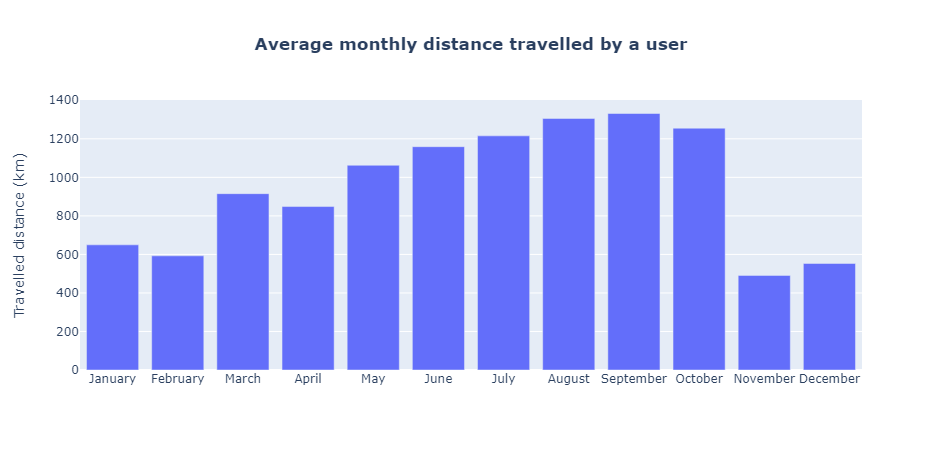

In [115]:
month_average_barchart(
    global_travels["month_name"],
    global_travels["distance"],
    "Average monthly distance travelled by a user",
    "Travelled distance (km)",
    False,
    "average_distance.html",
)

In [103]:
def average_barchart_selection_CH(
    df, xvalues_colname, yvalues_colname, title, ylabel, save_html, html_name
):
    """
    Plot an interactive barchart with country selection and shows travel statistics for a user living in the country selected.

    Arguments
    =========
    df : pandas dataframe
        dataframe representing yearly travels
    xvalues_colname : str
        name of the column representing months in yearly_travels dataframe
    yvalues_colname : str
        name of the column representing the statistic to plot in the yearly_travels dataframe
    title : str
        string representing the title of the graph
    ylabel : str
        string representing the y axis label
    save_html : bool
        boolean if set to true will save the plot to html
    html_name : str
        string representing the name of the html file to save
    """
    
    # removing "Unknown code"
    id_unknown_code = -7
    countries = np.delete(np.unique(np.array(df.country_name_user)), id_unknown_code)
    # we need to add this to select which trace
    # is going to be visible
    visible = countries

    # define traces and buttons at once
    traces = []
    buttons = []
    for country in countries:
        traces.append(
            go.Bar(
                x=df[df.country_name_user == country][xvalues_colname],
                y=df[df.country_name_user == country][yvalues_colname],
                visible=True if country == "Switzerland" else False,
            ),
        )

        buttons.append(
            dict(
                label=country,
                method="update",
                args=[
                    {"visible": list(visible == country)},
                    {"title": f"<b>{title} {country}</b>"},
                ],
            )
        )

    ID_switzerland = 121
    updatemenus = [
        {
            "active": ID_switzerland,
            "buttons": buttons,
        }
    ]

    # Show figure
    fig = go.Figure(data=traces, layout=dict(updatemenus=updatemenus))

    # This is in order to get the first title displayed correctly
    first_title = "Switzerland"
    fig.update_layout(
        title=f"<b>{title} {first_title}</b>",
        title_x=0.5,
        yaxis_title=ylabel,
    )
    fig.show()
    if save_html:
        fig.write_html(html_name)

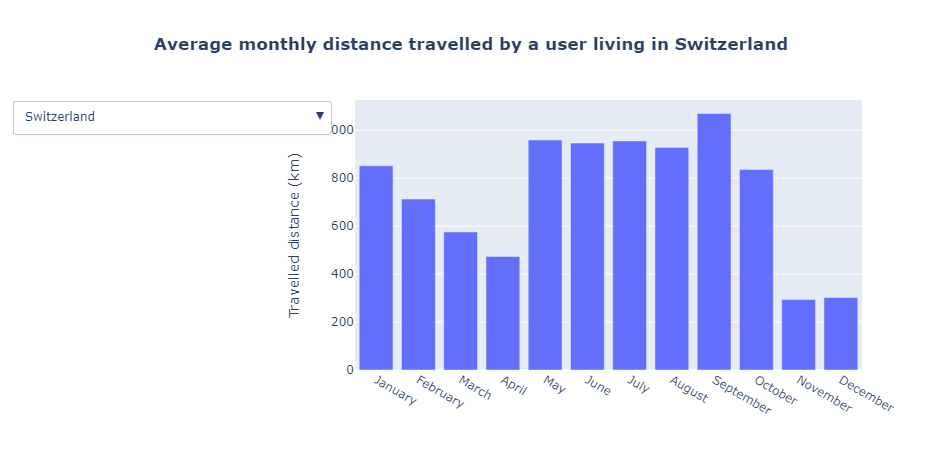

In [116]:
average_barchart_selection_CH(
    yearly_travels,
    "month_name",
    "distance_normalized",
    "Average monthly distance travelled by a user living in",
    "Travelled distance (km)",
    False,
    "distance_travelled.html",
)

Now we do the same for the monthy number of trips.

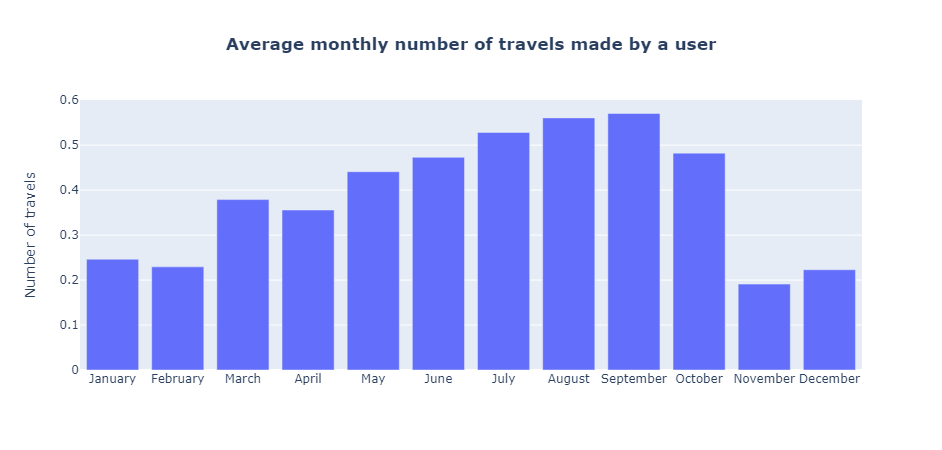

In [107]:
month_average_barchart(
    global_travels["month_name"],
    global_travels["count"],
    "Average monthly number of travels made by a user",
    "Number of travels",
    False,
    "global_number_trips_travelled",
)

In [108]:
average_barchart_selection_CH(
    yearly_travels,
    "month_name",
    "count_normalized",
    "Average monthly number of travels by a user living in",
    "Number of trips",
    False,
    "number_trips_travelled.html",
)

### Find the most visited destinations by country.

To analyze that question, we need to remove some travels. Indeed, we think that counting flight returning home from abroad should not be counted. However, domestic flights should still be counted as these can represent people visiting other places in their country.

Below we remove all flights which end in the home country of the user except if the starting point of the travel was in the home country of the user (domestic flight) and apply the same normalization by month as we did in the previous question.

In [109]:
travels_not_home_returns_b = travels_b[
    ~(
        (travels_b.country_user == travels_b.iso_country_end)
        & (travels_b.iso_country_end != travels_b.iso_country_start)
    )
]

end_country_b = (
    travels_not_home_returns_b.groupby(["country_user", "iso_country_end", "month"])
    .agg({"user": "count"})
    .rename(columns={"user": "number_of_trips"})
    .reset_index()
)

end_country_b = end_country_b.merge(months_counts_b.reset_index())

end_country_b["number_of_trips_normalized"] = (
    end_country_b["number_of_trips"] / end_country_b["year"]
)
end_country_b = (
    end_country_b.groupby(["country_user", "iso_country_end"])
    .agg({"number_of_trips_normalized": "sum"})
    .reset_index()
)

# Same for Gowalla
travels_not_home_returns_g = travels_g[
    ~(
        (travels_g.country_user == travels_g.iso_country_end)
        & (travels_g.iso_country_end != travels_g.iso_country_start)
    )
]

end_country_g = (
    travels_not_home_returns_g.groupby(["country_user", "iso_country_end", "month"])
    .agg({"user": "count"})
    .rename(columns={"user": "number_of_trips"})
    .reset_index()
)

end_country_g = end_country_g.merge(months_counts_g.reset_index())

end_country_g["number_of_trips_normalized"] = (
    end_country_g["number_of_trips"] / end_country_g["year"]
)
end_country_g = (
    end_country_g.groupby(["country_user", "iso_country_end"])
    .agg({"number_of_trips_normalized": "sum"})
    .reset_index()
)

end_country_b

country_user iso_country_end  number_of_trips_normalized
0              AE              BE                    0.500000
1              AE              CA                    0.333333
2              AE              CK                    0.500000
3              AE              CR                    0.333333
4              AE              DE                    0.333333
...           ...             ...                         ...
2110           ZA              US                    2.833333
2111           ZA              ZA                    7.833333
2112           ZA              ZM                    0.500000
2113           ZA              ZW                    0.333333
2114           ZM              BR                    0.333333

[2115 rows x 3 columns]

We now take the data of Brightkite and Gowalla together and then calculate for every country the percentage of trips to every country that is visited.

In [110]:
end_country = end_country_b.append(end_country_g, ignore_index=True)

end_country = (
    end_country.groupby(["country_user", "iso_country_end"])
    .sum()
    .reset_index()
    .sort_values("number_of_trips_normalized", ascending=False)
)

# Used to get the probabilities
total_normalized_trips = (
    end_country.groupby("country_user")[["number_of_trips_normalized"]]
    .sum()
    .reset_index()
    .rename(columns={"number_of_trips_normalized": "total_number_of_trips_normalized"})
)

end_country = end_country.merge(total_normalized_trips)
end_country["percentage_trips"] = (
    end_country["number_of_trips_normalized"]
    / end_country["total_number_of_trips_normalized"]
)
end_country.head()

country_user iso_country_end  number_of_trips_normalized  \
0           US              US                70127.000000   
1           US              CA                  736.500000   
2           US              GB                  615.166667   
3           US              MX                  298.333333   
4           US              DE                  271.666667   

   total_number_of_trips_normalized  percentage_trips  
0                      75469.166667          0.929214  
1                      75469.166667          0.009759  
2                      75469.166667          0.008151  
3                      75469.166667          0.003953  
4                      75469.166667          0.003600

We can now only select the top 10 destinations per country. Note that countries that have travelled to less than 10 countries will have fewer than 10 countries. We give as an example the top 10 most visited countries from Switzerland:

In [111]:
top_end_country = end_country.groupby("country_user").head(10)
top_end_country[top_end_country.country_user == 'CH']

country_user iso_country_end  number_of_trips_normalized  \
1477           CH              US                   79.833333   
1478           CH              DE                   62.666667   
1479           CH              FR                   54.666667   
1480           CH              GB                   44.166667   
1481           CH              ES                   26.666667   
1482           CH              NL                   20.666667   
1483           CH              AT                   17.666667   
1484           CH              IT                   10.833333   
1485           CH              SE                   10.000000   
1486           CH              PT                    7.666667   

      total_number_of_trips_normalized  percentage_trips  
1477                             439.0          0.181853  
1478                             439.0          0.142749  
1479                             439.0          0.124525  
1480                             439.0          0.100607  
1481                             439.0          0.060744  
1482                             439.0          0.047077  
1483                             439.0          0.040243  
1484                             439.0          0.024677  
1485                             439.0          0.022779  
1486                             439.0          0.017464

We see that people living in Switzerland mostly travel to:
1. The United States
2. Germany
3. France
4. Great Britain
5. Spain
6. The Netherlands
7. Austria
8. Italy
9. Sweden
10. Portugal

Now, we want to visualize the top visited countries by users of each country.

We add columns to get the 3 letter ISO code of the home countries and the names of both columns containing information about countries

In [113]:
countries2letters_3letters = {}
for country in pycountry.countries:
    countries2letters_3letters[country.alpha_2] = country.alpha_3

top_travels = top_end_country.copy()
top_travels["country_user"] = top_end_country.country_user.apply(
    lambda x: countries2letters_name.get(x, "Unknown code")
)
top_travels["iso_country_end"] = top_end_country.iso_country_end.apply(
    lambda x: countries2letters_3letters.get(x, "Unknown code")
)
top_travels["end_country_name"] = top_end_country.iso_country_end.apply(
    lambda x: countries2letters_name.get(x, "Unknown code")
)

# Formatting in percentage with 2 decimal values
top_travels["percentage_trips"] = round(top_end_country.percentage_trips * 100, 2)

top_travels.head()

country_user iso_country_end  number_of_trips_normalized  \
0  United States             USA                70127.000000   
1  United States             CAN                  736.500000   
2  United States             GBR                  615.166667   
3  United States             MEX                  298.333333   
4  United States             DEU                  271.666667   

   total_number_of_trips_normalized  percentage_trips end_country_name  
0                      75469.166667             92.92    United States  
1                      75469.166667              0.98           Canada  
2                      75469.166667              0.82   United Kingdom  
3                      75469.166667              0.40           Mexico  
4                      75469.166667              0.36          Germany

In [140]:
def top_10_plot(
    df,
    unknown_code_position,
    locations_col,
    locations_colname,
    colorbar_title,
    z_colname,
    colorscale_values,
    text_param1,
    text_param2,
    title,
    first_country_position,
    first_country,
    save_html,
    html_file_name
):
    """
    Plot an interactive map with country selection and shows top 10 statistics for a user living in the country selected.

    Arguments
    =========
    df : pandas dataframe
        dataframe representing yearly travels
    unknown_code_position : int
        code position representing the unknown category in the dataframe
    locations_colname : str
        name of the column representing the statistic to plot in the df dataframe
    colorbar_title : str
        string representing the title of the colorbar
    z_colname : str
        name of the column for the z value in the plot attributes
    colorscale_values : str
        string representing the color scale
    text_param1 : str
        text to print when hovering a country
    text_param2 : str
        text2 to print when hovering a country
    title : str
        text to print in the plot title
    first_country_position : int
        code of the default country
    first_country : str
        name of the default country
    save_html : bool
        boolean if set to true will save the plot to html
    html_name : str
        string representing the name of the html file to save
    """
    
    # We remove one entry which corresponds to "unknown code"
    countries_from = np.delete(
        np.unique(np.array(df[locations_col])), unknown_code_position
    )

    # we need to add this to select which trace
    # is going to be visible
    visible = countries_from

    # define traces and buttons at once
    traces = []
    buttons = []
    for country in countries_from:
        traces.append(
            go.Choropleth(
                locations=df[df[locations_col] == country][locations_colname],
                colorbar_title=colorbar_title,
                z=df[df[locations_col]== country][z_colname].astype(float),
                visible=True if country == "Switzerland" else False,
                colorscale=colorscale_values,
                text=df[df[locations_col] == country][text_param1]\
                        + "<br>"\
                        + df[df[locations_col] == country][z_colname].astype(str)\
                        + f"% of {text_param2}",
                hoverinfo="text",
            ),
        )

        buttons.append(
            dict(
                label=country,
                method="update",
                args=[
                    {"visible": list(visible == country)},
                    {
                        "title": f"<b>Top {len(df[df[locations_col] == country])} {title} from people living in {country}</b>"
                    },
                ],
            )
        )

    # We set the first visible button to be Switzerland
    updatemenus = [
        {
            "active": first_country_position,
            "buttons": buttons,
        }
    ]

    # Show figure
    fig = go.Figure(data=traces, layout=dict(updatemenus=updatemenus))
    fig.update_geos(projection_type="natural earth")

    # This is in order to get the first title displayed correctly
    first_title = first_country
    fig.update_layout(
        title=f"<b>Top 10 {title} from people living in {first_title}</b>",
        title_x=0.5,
    )
    if save_html:
        fig.write_html(html_file_name)
    fig.show()

Here's a plot representing the top 10 visited countries from people living in each country!

In [141]:
top_10_plot(
    top_travels,
    -8,
    'country_user',
    'iso_country_end',
    'Percentage of trips',
    'percentage_trips',
    "Reds",
    "end_country_name",
    "trips",
    'visited countries',
    124,
    'Switzerland',
    True,
    'top10visited.html',
)

### See if there is a conection between friends and visited countries.

To answer this question, we need to create a dataframe containing the friendships and the countries where live both users in the relationship.

To do this, we first need to change a bit the  dataframe containing a user and his home to get a dataframe containing a user and the country where he lives.

In [117]:
# homes_b = pd.read_pickle("./data/homes_b.pkl")
# homes_g = pd.read_pickle("./data/homes_g.pkl")

In [118]:
homes_b = homes_b.drop(columns=['cell_number', 'latitude', 'longitude'])
homes_g = homes_g.drop(columns=['cell_number', 'latitude', 'longitude'])

In [119]:
homes_b = homes_b.rename(columns={'user':'user1', 'country':'country_1'})
homes_g = homes_g.rename(columns={'user':'user1', 'country':'country_1'})

homes_b.head()

user1 country_1
0      0        US
1      2        US
2      8        US
3     12        US
4     13        US

Then, we add to it the friends of every user as well as the country where they live.

In [120]:
friends_countries_b = homes_b.merge(friendships_b, on='user1')
friends_countries_g = homes_g.merge(friendships_g, on='user1')

friends_countries_b.head()

user1 country_1  user2
0      0        US      1
1      0        US      2
2      0        US      3
3      0        US      4
4      0        US      5

In [121]:
homes_b = homes_b.rename(columns={'user1':'user2', 'country_1':'country_2'})
homes_g = homes_g.rename(columns={'user1':'user2', 'country_1':'country_2'})

homes_b.head()

user2 country_2
0      0        US
1      2        US
2      8        US
3     12        US
4     13        US

In [122]:
friends_countries_b = friends_countries_b.merge(homes_b, on='user2')
friends_countries_g = friends_countries_g.merge(homes_g, on='user2')

friends_countries_b.head()

user1 country_1  user2 country_2
0      0        US      1        US
1      2        US      1        US
2     52        US      1        US
3     88        US      1        US
4    111        US      1        US

We add a little differenciation to each username of the Gowalla users to that we can make a unique dataframe with both Gowalla and Brightkite data in order to do a unique a more precise analysis.

In [123]:
friends_countries_g['user2'] = friends_countries_g['user2'].astype(str) + '_g'
friends_countries_g['user1'] = friends_countries_g['user1'].astype(str) + '_g'

friends_countries_g.head()

user1 country_1 user2 country_2
0   0_g        US   1_g        FR
1   5_g        US   1_g        FR
2   7_g        US   1_g        FR
3  26_g        US   1_g        FR
4  42_g        US   1_g        FR

In [124]:
friends_countries = friends_countries_g.append(friends_countries_b)
friends_countries.head()

user1 country_1 user2 country_2
0   0_g        US   1_g        FR
1   5_g        US   1_g        FR
2   7_g        US   1_g        FR
3  26_g        US   1_g        FR
4  42_g        US   1_g        FR

Now we want to see for users of a given country the top countries with their friends. 
First we get the number of friendships between each pair of countries.

In [125]:
friends_countries = friends_countries.groupby(by=['country_1', 'country_2']).count()
friends_countries = friends_countries.reset_index()
friends_countries = friends_countries.drop(columns=['user1'])
friends_countries = friends_countries.sort_values(by=['country_1', 'user2'], ascending=False)

friends_countries = friends_countries.rename(columns={'user2':'number_friends'})
friends_countries.head(15)

country_1 country_2  number_friends
5095        ZW        US               3
5094        ZW        HK               2
5092        ZW        AU               1
5093        ZW        CH               1
5091        ZM        US              88
5077        ZM        CA               4
5083        ZM        GB               3
5078        ZM        CN               2
5082        ZM        FR               2
5084        ZM        JP               2
5088        ZM        SG               2
5076        ZM        AU               1
5079        ZM        DE               1
5080        ZM        DK               1
5081        ZM        FI               1

We want to get the probabilities that a user of a given country has a friend in another country. To do this we count the total number of friendships from one country and use this value to divide all friendships between pairs of countries.

In [126]:
total_friends_country = friends_countries.groupby(by=['country_1']).sum().reset_index()
total_friends_country = total_friends_country .rename(columns={'number_friends':'total_number_friends'})
total_friends_country.head()

country_1  total_number_friends
0        AD                     1
1        AE                   612
2        AF                    20
3        AG                    49
4        AL                     4

We can put all the information together in order to get a dataframe containing each pair of countries linked by friendships, the number of friendships which links them, and the number of total friends the first country has.

In [127]:
friends_countries = friends_countries.merge(total_friends_country, on='country_1')
friends_countries.head()

country_1 country_2  number_friends  total_number_friends
0        ZW        US               3                     7
1        ZW        HK               2                     7
2        ZW        AU               1                     7
3        ZW        CH               1                     7
4        ZM        US              88                   112

We now want to compute the probability of each friendships for every country to know a bit the degree of afinity a country has with the others.

In [128]:
friends_countries['proba_friends'] = friends_countries['number_friends']/friends_countries['total_number_friends']
friends_countries.head()

country_1 country_2  number_friends  total_number_friends  proba_friends
0        ZW        US               3                     7       0.428571
1        ZW        HK               2                     7       0.285714
2        ZW        AU               1                     7       0.142857
3        ZW        CH               1                     7       0.142857
4        ZM        US              88                   112       0.785714

In [129]:
top_friendships = friends_countries.sort_values('proba_friends', ascending=False).groupby('country_1').head(10)

In [130]:
top_friendships["country_1_name"] = top_friendships.country_1.apply(
    lambda x: countries2letters_name.get(x, "Unknown code")
)
top_friendships["country_2_3letters"] = top_friendships.country_2.apply(
    lambda x: countries2letters_3letters.get(x, "Unknown code")
)
top_friendships["country_2_name"] = top_friendships.country_2.apply(
    lambda x: countries2letters_name.get(x, "Unknown code")
)
top_friendships["proba_friends"] = round(top_friendships.proba_friends * 100, 2)

top_friendships.head()

country_1 country_2  number_friends  total_number_friends  proba_friends  \
5095        AD        US               1                     1          100.0   
643         SY        US               5                     5          100.0   
564         TL        US               1                     1          100.0   
2206        LA        US               1                     1          100.0   
4432        BT        US               1                     1          100.0   

                        country_1_name country_2_3letters country_2_name  
5095                           Andorra                USA  United States  
643               Syrian Arab Republic                USA  United States  
564                        Timor-Leste                USA  United States  
2206  Lao People's Democratic Republic                USA  United States  
4432                            Bhutan                USA  United States

We check the top friendship countries of people living in Switzerland to have an overview.

In [131]:
top_friendships[top_friendships.country_1_name =='Switzerland'].country_2_name

4226     United States
4227    United Kingdom
4228             Japan
4229           Germany
4231            Sweden
4230            Canada
4232         Australia
4233            France
4234             Italy
4235       Switzerland
Name: country_2_name, dtype: object

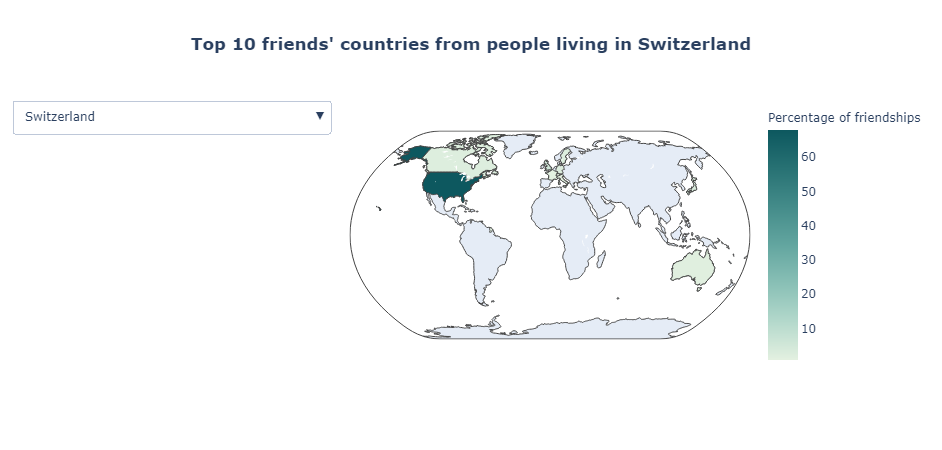

In [142]:
top_10_plot(
    top_friendships,
    -9,
    'country_1_name',
    'country_2_3letters',
    'Percentage of friendships',
    'proba_friends',
    "mint",
    "country_2_name",
    "friendships",
    "friends' countries",
    149,
    'Switzerland',
    True,
    'top10frienships.html',
)

### Check if it is possible to predict home areas based on travel patterns.

For that question, we aim to have a dataframe that looks like ```userID | home_country | Jan | ... | Dec``` with the number of trips and the distance that a user did during each month. Based on that, we will see if we can accurately predict the home country of the user. 

We need to differentiate betweem Gowalla and Brightkite because we want to append the two travels dataframes. To do that, we append a \_g suffix to all users from gowalla.

In [143]:
travels_g["user"] = travels_g["user"].apply(lambda name: str(name) + "_g")

In [144]:
travels_per_month_b = (
    travels_b[["user", "country_user", "month", "year", "distance_airports"]]
    .groupby(["user", "country_user", "month"])
    .agg({"year": "count", "distance_airports": "mean"})
    .rename(columns={"year": "number_of_trips", "distance_airports": "mean_distance_traveled"})
    .reset_index()
)

travels_per_month_g = (
    travels_g[["user", "country_user", "month", "year", "distance_airports"]]
    .groupby(["user", "country_user", "month"])
    .agg({"year": "count", "distance_airports": "mean"})
    .rename(columns={"year": "number_of_trips", "distance_airports": "mean_distance_traveled"})
    .reset_index()
)

travels_per_month = travels_per_month_b.append(travels_per_month_g)

print(travels_per_month.shape)
travels_per_month.head()

(111188, 5)


user country_user  month  number_of_trips  mean_distance_traveled
0    0           US      1                4             2076.944021
1    0           US      2                2             1553.262281
2    0           US      3                3             1739.749953
3    0           US      4                2             2307.191776
4    0           US      5                3             1553.262281

Now because some month appear more than others, we need to normalize by the count of months. We already built dataframe containing the number of months in each year.

In [145]:
months_counts = months_counts_b + months_counts_g

In [146]:
travels_per_month = travels_per_month.merge(months_counts, on='month')

In [147]:
travels_per_month["number_of_trips"] = travels_per_month["number_of_trips"] / travels_per_month["year"]
travels_per_month["mean_distance_traveled"] = travels_per_month["mean_distance_traveled"] / travels_per_month["year"]
travels_per_month = travels_per_month.drop(columns=["year"])

In [148]:
travels_per_month.head()

user country_user  month  number_of_trips  mean_distance_traveled
0    0           US      1         1.333333              692.314674
1    2           US      1         2.000000              479.101082
2    3           US      1         0.666667             1262.663931
3    4           FI      1         0.333333             2908.938665
4    6           US      1         0.666667              987.781213

Now to have the desired dataframe, we can pivot the dataframe on the month column, by specifying the two values column of interest.

In [149]:
travels_per_month = travels_per_month.pivot(
    index=["user", "country_user"], columns="month", values=["number_of_trips", "mean_distance_traveled"]
).fillna(0)
travels_per_month.head()

number_of_trips                                          \
month                          1         2    3    4    5    6    7    8    
user country_user                                                           
0    US                  1.333333  0.666667  0.6  0.4  0.6  0.8  0.0  0.0   
2    US                  2.000000  0.000000  0.0  0.0  0.8  0.2  0.8  0.4   
3    US                  0.666667  0.000000  1.6  0.4  0.2  0.0  0.0  1.0   
4    FI                  0.333333  1.000000  0.0  1.0  0.2  0.0  0.0  0.4   
5    US                  0.000000  0.000000  0.0  0.8  0.2  0.0  1.4  1.0   

                             ... mean_distance_traveled               \
month               9    10  ...                     3            4    
user country_user            ...                                       
0    US            1.0  0.6  ...             347.949991   461.438355   
2    US            0.4  0.0  ...               0.000000     0.000000   
3    US            0.4  0.8  ...             319.443194   490.074266   
4    FI            0.4  2.2  ...               0.000000  1790.133077   
5    US            0.4  0.6  ...               0.000000   455.060069   

                                                                     \
month                       5           6           7            8    
user country_user                                                     
0    US             310.652456  293.883631    0.000000     0.000000   
2    US             250.687437  134.839114  201.442799  1499.764973   
3    US             143.716909    0.000000    0.000000   521.859538   
4    FI            1742.432794    0.000000    0.000000   296.017702   
5    US             664.332737    0.000000  973.269319   828.460479   

                                                                       
month                       9            10           11           12  
user country_user                                                      
0    US             802.093851   310.652456   430.337789   517.754094  
2    US            1598.970347     0.000000     0.000000     0.000000  
3    US             473.770518   424.219469  1152.787256  1254.137732  
4    FI            1031.006026  1530.396407   616.178595  2906.496661  
5    US            1204.691797   616.223140     0.000000  1145.265424  

[5 rows x 24 columns]

We rename the columns to have the name of the months.

In [150]:
travels_per_month.columns = range(travels_per_month.shape[1])
travels_per_month = travels_per_month.rename(
    columns={
        0: "Jan_trips",
        1: "Feb_trips",
        2: "Mar_trips",
        3: "Apr_trips",
        4: "May_trips",
        5: "Jun_trips",
        6: "Jul_trips",
        7: "Aug_trips",
        8: "Sep_trips",
        9: "Oct_trips",
        10: "Nov_trips",
        11: "Dec_trips",
        12: "Jan_distances",
        13: "Feb_distances",
        14: "Mar_distances",
        15: "Apr_distances",
        16: "May_distances",
        17: "Jun_distances",
        18: "Jul_distances",
        19: "Aug_distances",
        20: "Sep_distances",
        21: "Oct_distances",
        22: "Nov_distances",
        23: "Dec_distances"
    }
)

In [151]:
travels_per_month = travels_per_month.reset_index()

In [152]:
travels_per_month.head()

user country_user  Jan_trips  Feb_trips  Mar_trips  Apr_trips  May_trips  \
0    0           US   1.333333   0.666667        0.6        0.4        0.6   
1    2           US   2.000000   0.000000        0.0        0.0        0.8   
2    3           US   0.666667   0.000000        1.6        0.4        0.2   
3    4           FI   0.333333   1.000000        0.0        1.0        0.2   
4    5           US   0.000000   0.000000        0.0        0.8        0.2   

   Jun_trips  Jul_trips  Aug_trips  ...  Mar_distances  Apr_distances  \
0        0.8        0.0        0.0  ...     347.949991     461.438355   
1        0.2        0.8        0.4  ...       0.000000       0.000000   
2        0.0        0.0        1.0  ...     319.443194     490.074266   
3        0.0        0.0        0.4  ...       0.000000    1790.133077   
4        0.0        1.4        1.0  ...       0.000000     455.060069   

   May_distances  Jun_distances  Jul_distances  Aug_distances  Sep_distances  \
0     310.652456     293.883631       0.000000       0.000000     802.093851   
1     250.687437     134.839114     201.442799    1499.764973    1598.970347   
2     143.716909       0.000000       0.000000     521.859538     473.770518   
3    1742.432794       0.000000       0.000000     296.017702    1031.006026   
4     664.332737       0.000000     973.269319     828.460479    1204.691797   

   Oct_distances  Nov_distances  Dec_distances  
0     310.652456     430.337789     517.754094  
1       0.000000       0.000000       0.000000  
2     424.219469    1152.787256    1254.137732  
3    1530.396407     616.178595    2906.496661  
4     616.223140       0.000000    1145.265424  

[5 rows x 26 columns]

Now, we tried to predict the ```country_user``` feature, but our model gave bad results because we had too many unbalanced classes. What we propose here, is to predict the continent in which the user lives. This leads to greater classes with more data.

In [153]:
def to_continent_code(x):
    """
    Takes an alpha-2 country code and returns the continent code.

    Arguments
    =========
    x : str
        string representing the alpha-2 code of a country

    Returns
    =======
    continent_code : str
        continent code of the country
    """
    continent_code = ""
    try:
        continent_code = pc.country_alpha2_to_continent_code(x)
    except:
        continent_code = "Unknown"
    return continent_code

We define a new column representing the continent of the user.

In [154]:
travels_per_month["continent_user"] = travels_per_month["country_user"].apply(
    lambda x: to_continent_code(x)
)
travels_per_month.head()

user country_user  Jan_trips  Feb_trips  Mar_trips  Apr_trips  May_trips  \
0    0           US   1.333333   0.666667        0.6        0.4        0.6   
1    2           US   2.000000   0.000000        0.0        0.0        0.8   
2    3           US   0.666667   0.000000        1.6        0.4        0.2   
3    4           FI   0.333333   1.000000        0.0        1.0        0.2   
4    5           US   0.000000   0.000000        0.0        0.8        0.2   

   Jun_trips  Jul_trips  Aug_trips  ...  Apr_distances  May_distances  \
0        0.8        0.0        0.0  ...     461.438355     310.652456   
1        0.2        0.8        0.4  ...       0.000000     250.687437   
2        0.0        0.0        1.0  ...     490.074266     143.716909   
3        0.0        0.0        0.4  ...    1790.133077    1742.432794   
4        0.0        1.4        1.0  ...     455.060069     664.332737   

   Jun_distances  Jul_distances  Aug_distances  Sep_distances  Oct_distances  \
0     293.883631       0.000000       0.000000     802.093851     310.652456   
1     134.839114     201.442799    1499.764973    1598.970347       0.000000   
2       0.000000       0.000000     521.859538     473.770518     424.219469   
3       0.000000       0.000000     296.017702    1031.006026    1530.396407   
4       0.000000     973.269319     828.460479    1204.691797     616.223140   

   Nov_distances  Dec_distances  continent_user  
0     430.337789     517.754094              NA  
1       0.000000       0.000000              NA  
2    1152.787256    1254.137732              NA  
3     616.178595    2906.496661              EU  
4       0.000000    1145.265424              NA  

[5 rows x 27 columns]

In [155]:
travels_per_month.shape

(50290, 27)

In [156]:
travels_per_month.continent_user.value_counts()

NA         32293
EU         13255
AS          3347
OC           962
SA           256
AF           176
Unknown        1
Name: continent_user, dtype: int64

We can observe that we have a lot of class imbalance. In order for the model to work, we aim to take 3347 users for each continents as the is the maximum number of users for Asia. This will allow us to have a more balanced dataset, and more data for each continent. Hence here we want to predict if a user is American, European or Asian based on his travel patterns over the year.

In [157]:
ml_data = travels_per_month.copy()
continent_counts = ml_data["continent_user"].value_counts()
ml_data = ml_data.loc[
    ml_data["continent_user"].isin(
        continent_counts.index[continent_counts > 1000]
    )  # Remove the unknown continent, Africa, south America, Oceania
]
ml_data.continent_user.value_counts()

NA    32293
EU    13255
AS     3347
Name: continent_user, dtype: int64

For each continent, we also want to take the users that travels the most. This is important because we assume that the users that are using more the application capturing checkins are the one that are more likely to represent their country and its travel patterns.

In [158]:
ml_data = ml_data.sort_values(
    [
        "Jan_trips",
        "Feb_trips",
        "Mar_trips",
        "Apr_trips",
        "May_trips",
        "Jun_trips",
        "Jul_trips",
        "Aug_trips",
        "Sep_trips",
        "Oct_trips",
        "Nov_trips",
        "Dec_trips",
        "Jan_distances",
        "Feb_distances",
        "Mar_distances",
        "Apr_distances",
        "May_distances",
        "Jun_distances",
        "Jul_distances",
        "Aug_distances",
        "Sep_distances",
        "Oct_distances",
        "Nov_distances",
        "Dec_distances",
    ],
    ascending=False,
)

Finally, for each continent we sample the 3347 users that travel the most by taking the head in each sorted group. 

In [159]:
main_continents = ml_data.continent_user.value_counts().keys().values

for c in main_continents:
    local_df = ml_data[ml_data["continent_user"] == c].head(3347)
    ml_data = ml_data[ml_data.continent_user != c]
    ml_data = ml_data.append(local_df)

ml_data.continent_user.value_counts()

EU    3347
NA    3347
AS    3347
Name: continent_user, dtype: int64

In [160]:
ml_data.sample(5)

user country_user  Jan_trips  Feb_trips  Mar_trips  Apr_trips  \
12943     38274           CN   0.000000   0.000000        0.0        0.0   
10506     27597           CN   0.000000   0.000000        0.0        0.0   
18478  109486_g           TH   0.000000   0.000000        0.0        0.2   
22322  126262_g           US   1.000000   0.333333        0.0        0.0   
30872    1941_g           US   0.333333   1.333333        0.4        0.0   

       May_trips  Jun_trips  Jul_trips  Aug_trips  ...  Apr_distances  \
12943        0.0        0.0        0.0        0.0  ...        0.00000   
10506        0.0        0.0        0.0        0.0  ...        0.00000   
18478        0.0        0.2        0.0        0.0  ...      113.54471   
22322        0.2        0.0        0.2        0.2  ...        0.00000   
30872        0.0        0.0        0.0        0.0  ...        0.00000   

       May_distances  Jun_distances  Jul_distances  Aug_distances  \
12943       0.000000       0.000000       0.000000       0.000000   
10506       0.000000       0.000000       0.000000       0.000000   
18478       0.000000     119.379089       0.000000       0.000000   
22322     618.577149       0.000000     309.204922     309.204922   
30872       0.000000       0.000000       0.000000       0.000000   

       Sep_distances  Oct_distances  Nov_distances  Dec_distances  \
12943            0.0     478.439543     482.361669       0.000000   
10506            0.0       0.000000     409.840446       0.000000   
18478            0.0       0.000000       0.000000       0.000000   
22322            0.0       0.000000       0.000000     708.038839   
30872            0.0       0.000000       0.000000       0.000000   

       continent_user  
12943              AS  
10506              AS  
18478              AS  
22322              NA  
30872              NA  

[5 rows x 27 columns]

### Predict the continent where users live

We need to encode the continent feature to numbers. Because we don't have any arithmetical links between continent, we need to encode them using OrdinalEncoder.

In [161]:
ord_enc = OrdinalEncoder()
ml_data["continent_user"] = ord_enc.fit_transform(ml_data[["continent_user"]]).astype('int')

In [162]:
ml_data = ml_data.drop(columns=['user', 'country_user'])
ml_data.head()

Jan_trips  Feb_trips  Mar_trips  Apr_trips  May_trips  Jun_trips  \
40440  49.666667   0.000000        0.0        0.0        0.0        0.0   
8499   12.333333   7.666667        5.0        2.8        0.0        0.0   
3036    9.333333  19.333333        7.2        7.6        5.6        0.4   
3433    9.333333   2.666667        1.2        0.0        0.2        0.2   
7674    7.666667   0.000000        0.0        0.0        0.0        0.0   

       Jul_trips  Aug_trips  Sep_trips  Oct_trips  ...  Apr_distances  \
40440        0.0        0.0        0.0        0.0  ...       0.000000   
8499         0.0        0.0        0.0        0.0  ...     146.742809   
3036         0.0        0.8        0.0        1.0  ...     405.663691   
3433         0.2        0.6        0.0        0.0  ...       0.000000   
7674         0.0        0.0        0.0        0.0  ...       0.000000   

       May_distances  Jun_distances  Jul_distances  Aug_distances  \
40440       0.000000       0.000000       0.000000       0.000000   
8499        0.000000       0.000000       0.000000       0.000000   
3036      405.663691     302.271225       0.000000     415.640208   
3433      351.253013     351.253013     351.253013     351.253013   
7674        0.000000       0.000000       0.000000       0.000000   

       Sep_distances  Oct_distances  Nov_distances  Dec_distances  \
40440            0.0       0.000000       0.000000       0.000000   
8499             0.0       0.000000       0.000000     344.020530   
3036             0.0     416.603058     676.106151     676.106151   
3433             0.0       0.000000       0.000000       0.000000   
7674             0.0       0.000000       0.000000       0.000000   

       continent_user  
40440               2  
8499                2  
3036                2  
3433                2  
7674                2  

[5 rows x 25 columns]

Here, we sample the interesting features for the prediction and define the target values.

In [163]:
SEED = 0

features = set(ml_data.columns) - set(["continent_user"])
X = ml_data[features]
y = ml_data["continent_user"].values
print(X.shape, y.shape)

(10041, 24) (10041,)


In [164]:
X.head()

Jan_trips  Oct_trips  May_distances  Dec_distances  Feb_trips  \
40440  49.666667        0.0       0.000000       0.000000   0.000000   
8499   12.333333        0.0       0.000000     344.020530   7.666667   
3036    9.333333        1.0     405.663691     676.106151  19.333333   
3433    9.333333        0.0     351.253013       0.000000   2.666667   
7674    7.666667        0.0       0.000000       0.000000   0.000000   

       Aug_trips  Nov_trips  Sep_trips  Sep_distances  Jul_trips  ...  \
40440        0.0   0.000000        0.0            0.0        0.0  ...   
8499         0.0   0.000000        0.0            0.0        0.0  ...   
3036         0.8   0.666667        0.0            0.0        0.0  ...   
3433         0.6   0.000000        0.0            0.0        0.2  ...   
7674         0.0   0.000000        0.0            0.0        0.0  ...   

       Jan_distances  Mar_trips  Apr_distances  Jul_distances  May_trips  \
40440    1418.649336        0.0       0.000000       0.000000        0.0   
8499      244.825933        5.0     146.742809       0.000000        0.0   
3036      676.106151        7.2     405.663691       0.000000        5.6   
3433      558.925202        1.2       0.000000     351.253013        0.2   
7674     2106.733178        0.0       0.000000       0.000000        0.0   

       Feb_distances  Jun_trips  Mar_distances  Nov_distances  Dec_trips  
40440       0.000000        0.0       0.000000       0.000000   0.000000  
8499      253.948389        0.0     169.376335       0.000000   7.333333  
3036      676.106151        0.4     419.337899     676.106151  14.333333  
3433      585.847628        0.2     351.934516       0.000000   0.000000  
7674        0.000000        0.0       0.000000       0.000000   0.000000  

[5 rows x 24 columns]

First let's visualize the data in two dimensions

In [165]:
pca = PCA(n_components=2).fit(X)
pca_2d = pca.transform(X)

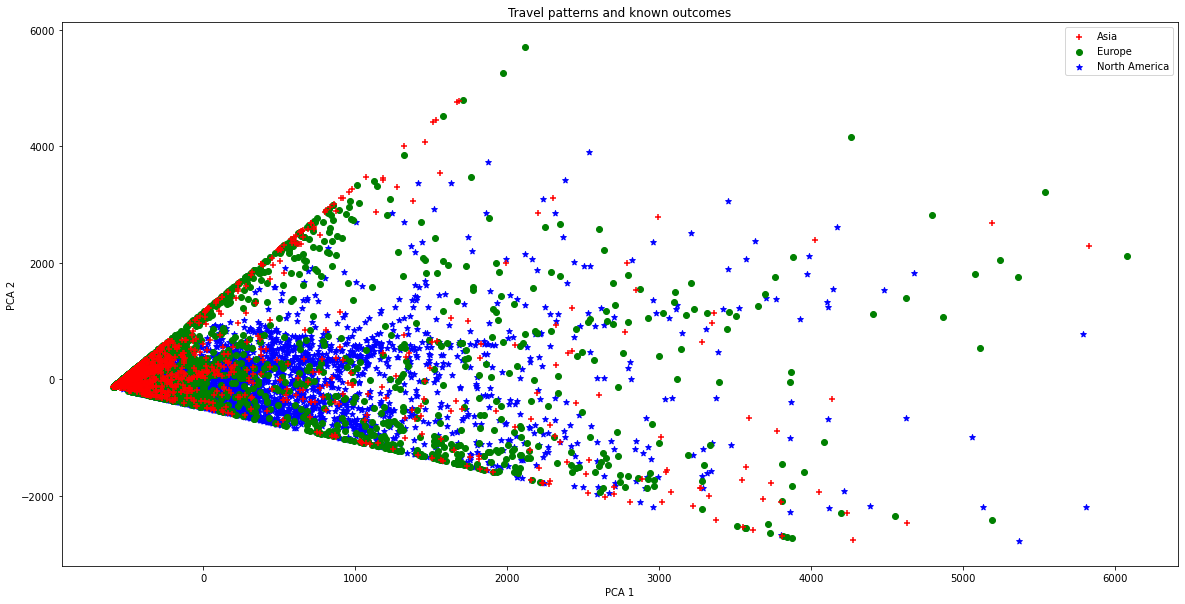

In [166]:
fig, ax = plt.subplots(figsize=(20, 10))

for i in range(0, pca_2d.shape[0]):
    if y[i] == 0:
        c1 = pl.scatter(pca_2d[i, 0], pca_2d[i, 1], c="r", marker="+")
    elif y[i] == 1:
        c2 = pl.scatter(pca_2d[i, 0], pca_2d[i, 1], c="g", marker="o")
    elif y[i] == 2:
        c3 = pl.scatter(pca_2d[i, 0], pca_2d[i, 1], c="b", marker="*")
pl.legend([c1, c2, c3], ["Asia", "Europe", "North America"])

pl.title("Travel patterns and known outcomes")
pl.xlabel("PCA 1")
pl.ylabel("PCA 2")
plt.savefig('pca.png')
pl.show()

Even if we plotted it in two dimension, we can already see that it may be difficult for a simple algorithm to find different behaviors for each continent based on travel patterns. However, even with the data we have we can already see some differences. Hence there is hope for good results.

We split the data into a training, a validation and a test set. 

In [167]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=SEED
)
print(X_train.shape, X_val.shape, X_test.shape)

(6024, 24) (2008, 24) (2009, 24)


Standardize the data in the training set, the validation set and the testing set to have better comparisons.

In [168]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

#### Logistic Regression

In [169]:
log = LogisticRegression(solver="lbfgs")
log.fit(X_train, y_train)
log.score(X_test, y_test)

0.726231956197113

#### Random Forest

In [170]:
rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=SEED)

In [171]:
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.7441513190642111

#### Neural Network

We append the neural netowrk in a pipeline to avoid information leakage during training and tuning.

In [172]:
estimators = []
nn = MLPClassifier(alpha=1e-5, max_iter=10000, random_state=SEED)
estimators.append(('neural_net', nn))  # use a MLP Classifier
pipeline = Pipeline(estimators)

We tune the hidden layer sizes of the network.

In [173]:
results = []
for i in range(2, 8):
    for j in range(2, 8):
        pipeline.set_params(neural_net__hidden_layer_sizes=(i, j))
        pipeline.fit(X_train, y_train)
        results.append(((i, j), pipeline.score(X_val, y_val)))

In [174]:
best_size = sorted(results, key=lambda x: x[1])[-1][0] #Take the last of the sorted list to get the max

print('Best value of hidden_layer_size = {}'.format(best_size))

Best value of hidden_layer_size = (3, 7)


We test our model on a final testing set.

In [175]:
# Test final model
pipeline.set_params(neural_net__hidden_layer_sizes = best_size)
pipeline.fit(X_train, y_train) #Train on the train set

#Compare to y_test
pipeline.score(X_test, y_test)

0.8043802887008462

Here we applied three different classification algorithms for a problem of 3 balanced classes. Since classes are balanced and having false positives or negatives does not impact differently the results, we consider that accuracy is a good measure here of how the algorithms perform. 

Predicting at random would yield an accuracy of 33%. Here we obtained an accuracy of 80.4% using the neural network which is much better than random predictions. This implies that predicting the continent where a user lives is possible using travel patterns over a year. However, because the data is biased regarding countries in order to predict over all continents or even more, by countries, we would need more balanced data. This is very encouraging because with enough data representing the 3 main continents, our model can definitely predict in which continent a user lives based on his travel patterns.